In [110]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import os
import matplotlib.pyplot as plt
import functools
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [111]:
# general settings
class CFG:
    data_path = './../data'
    img_dim1 = 20
    img_dim2 = 10
    

# adjust the parameters for displayed figures
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

# NSW forecast demand

In [112]:
nsw_forecastdemand = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'forecastdemand_nsw.csv'), 
    parse_dates=['LASTCHANGED', 'DATETIME']
)

In [113]:
nsw_forecastdemand.head(10)

,PREDISPATCHSEQNO,REGIONID,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
0,2009123018,NSW1,71,7832.04,2009-12-30 12:31:49,2010-01-01
1,2009123019,NSW1,70,7832.04,2009-12-30 13:01:43,2010-01-01
2,2009123020,NSW1,69,7832.03,2009-12-30 13:31:36,2010-01-01
3,2009123021,NSW1,68,7832.03,2009-12-30 14:01:44,2010-01-01
4,2009123022,NSW1,67,7830.96,2009-12-30 14:31:35,2010-01-01
5,2009123023,NSW1,66,7842.03,2009-12-30 15:01:42,2010-01-01
6,2009123024,NSW1,65,7841.08,2009-12-30 15:31:50,2010-01-01
7,2009123025,NSW1,64,7842.07,2009-12-30 16:01:43,2010-01-01
8,2009123026,NSW1,63,7841.90,2009-12-30 16:31:34,2010-01-01
9,2009123027,NSW1,62,7841.90,2009-12-30 17:01:39,2010-01-01



- we should try to understand what `periodid` represents
- for now we will `groupby` datetime and use `mean()` as the agg function

In [114]:
nsw_forecastdemand = nsw_forecastdemand.groupby('DATETIME').agg({'FORECASTDEMAND': 'mean'}).reset_index()

- reset the index to datetime

In [115]:
nsw_forecastdemand.set_index('DATETIME', inplace=True)

- do we need any data aside from forecast demand and datetime? I don't see any value in `PREDISPATCHSEQNO`, `REGIONID`, `LASTCHANGED` and of course `PERIODID` disappears

In [116]:
nsw_forecastdemand.head()

,FORECASTDEMAND
DATETIME,
2010-01-01 00:00:00,7824.411831
2010-01-01 00:30:00,7680.510417
2010-01-01 01:00:00,7428.971370
2010-01-01 01:30:00,7084.802162
2010-01-01 02:00:00,6751.369600


# NSW actual demand

In [117]:
nsw_totaldemand = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'totaldemand_nsw.csv'), 
    parse_dates=['DATETIME'],
    dayfirst=True,
    index_col='DATETIME',
    usecols=['DATETIME', 'TOTALDEMAND']
)

In [118]:
nsw_totaldemand.head()

,TOTALDEMAND
DATETIME,
2010-01-01 00:00:00,8038.00
2010-01-01 00:30:00,7809.31
2010-01-01 01:00:00,7483.69
2010-01-01 01:30:00,7117.23
2010-01-01 02:00:00,6812.03


# NSW temperature

In [119]:
nsw_temperature = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'temperature_nsw.csv'), 
    parse_dates=['DATETIME'], 
    dayfirst=True,
    index_col='DATETIME',
    usecols=['DATETIME', 'TEMPERATURE']
)

In [120]:
nsw_temperature.head()

,TEMPERATURE
DATETIME,
2010-01-01 00:00:00,23.1
2010-01-01 00:01:00,23.1
2010-01-01 00:30:00,22.9
2010-01-01 00:50:00,22.7
2010-01-01 01:00:00,22.6


# merge

In [121]:
dfs = [nsw_totaldemand, nsw_forecastdemand, nsw_temperature]

In [122]:
nsw_df = functools.reduce(
    lambda left, right: 
    pd.merge(
        left, 
        right, 
        left_index=True, 
        right_index=True, 
        how='inner'
    ), dfs
)

In [123]:
nsw_df.head()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE
DATETIME,,,
2010-01-01 00:00:00,8038.00,7824.411831,23.1
2010-01-01 00:30:00,7809.31,7680.510417,22.9
2010-01-01 01:00:00,7483.69,7428.971370,22.6
2010-01-01 01:30:00,7117.23,7084.802162,22.5
2010-01-01 02:00:00,6812.03,6751.369600,22.5


# EDA

In [124]:
nsw_df.describe()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE
count,195947.000000,195947.000000,195947.000000
mean,8111.924589,8105.831984,17.530995
std,1299.171401,1302.726720,5.884212
min,5074.630000,4878.596667,-1.300000
25%,7149.430000,7128.798078,13.500000
50%,8052.180000,8060.368868,17.900000
75%,8956.985000,8963.019304,21.500000
max,14579.860000,14601.171964,44.700000


In [125]:
nsw_df.corr()

,TOTALDEMAND,FORECASTDEMAND,TEMPERATURE
TOTALDEMAND,1.000000,0.987160,0.149045
FORECASTDEMAND,0.987160,1.000000,0.144881
TEMPERATURE,0.149045,0.144881,1.000000


<Axes: >

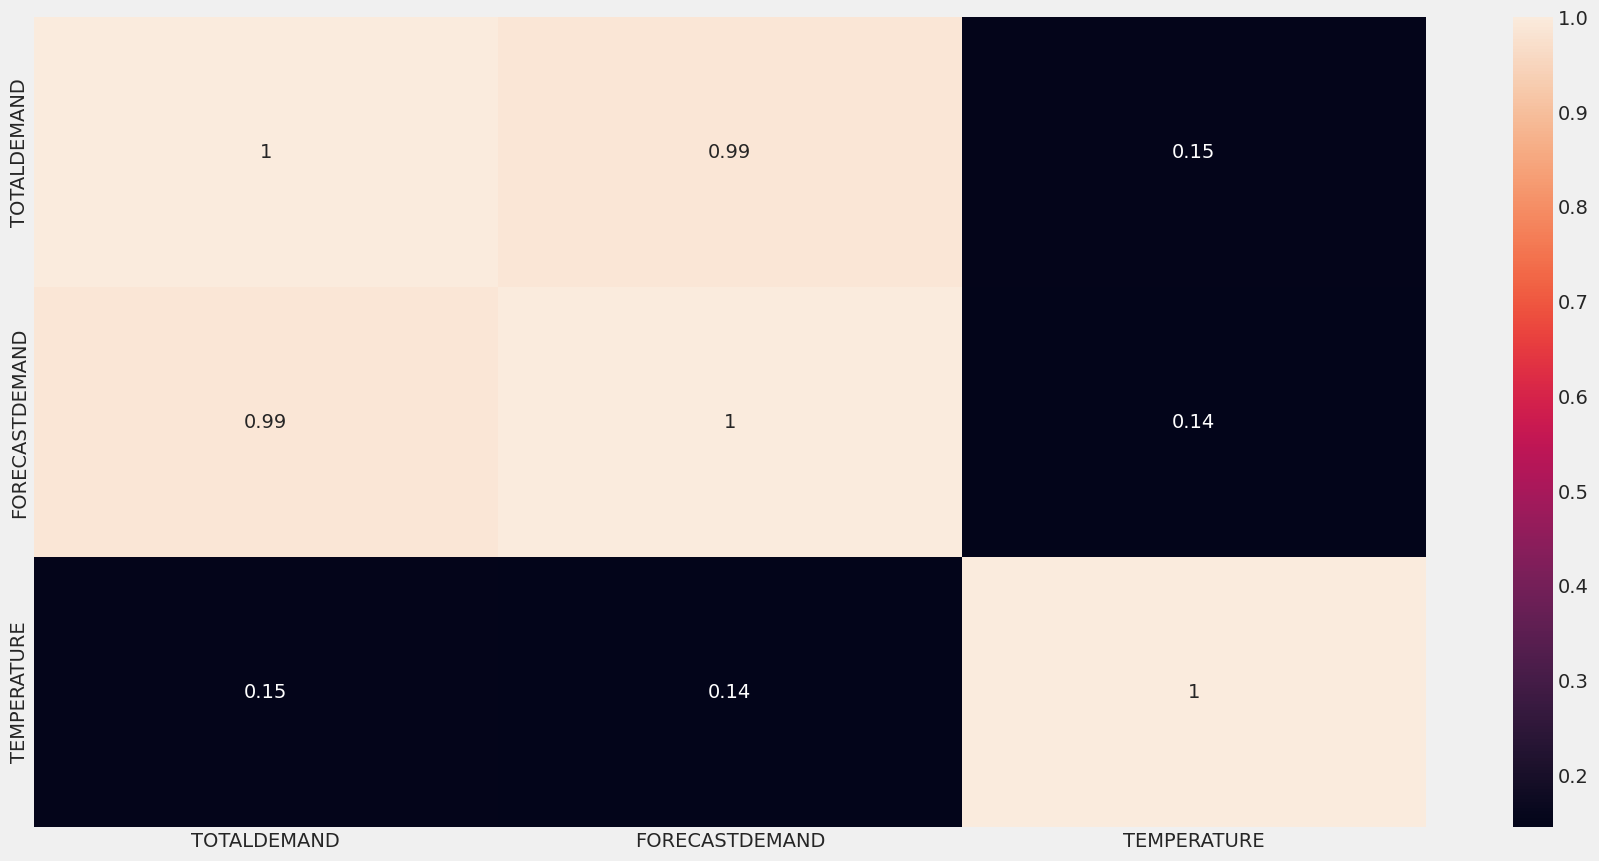

In [126]:
sns.heatmap(nsw_df.corr(), annot=True)

# Forecast and actual demand over time

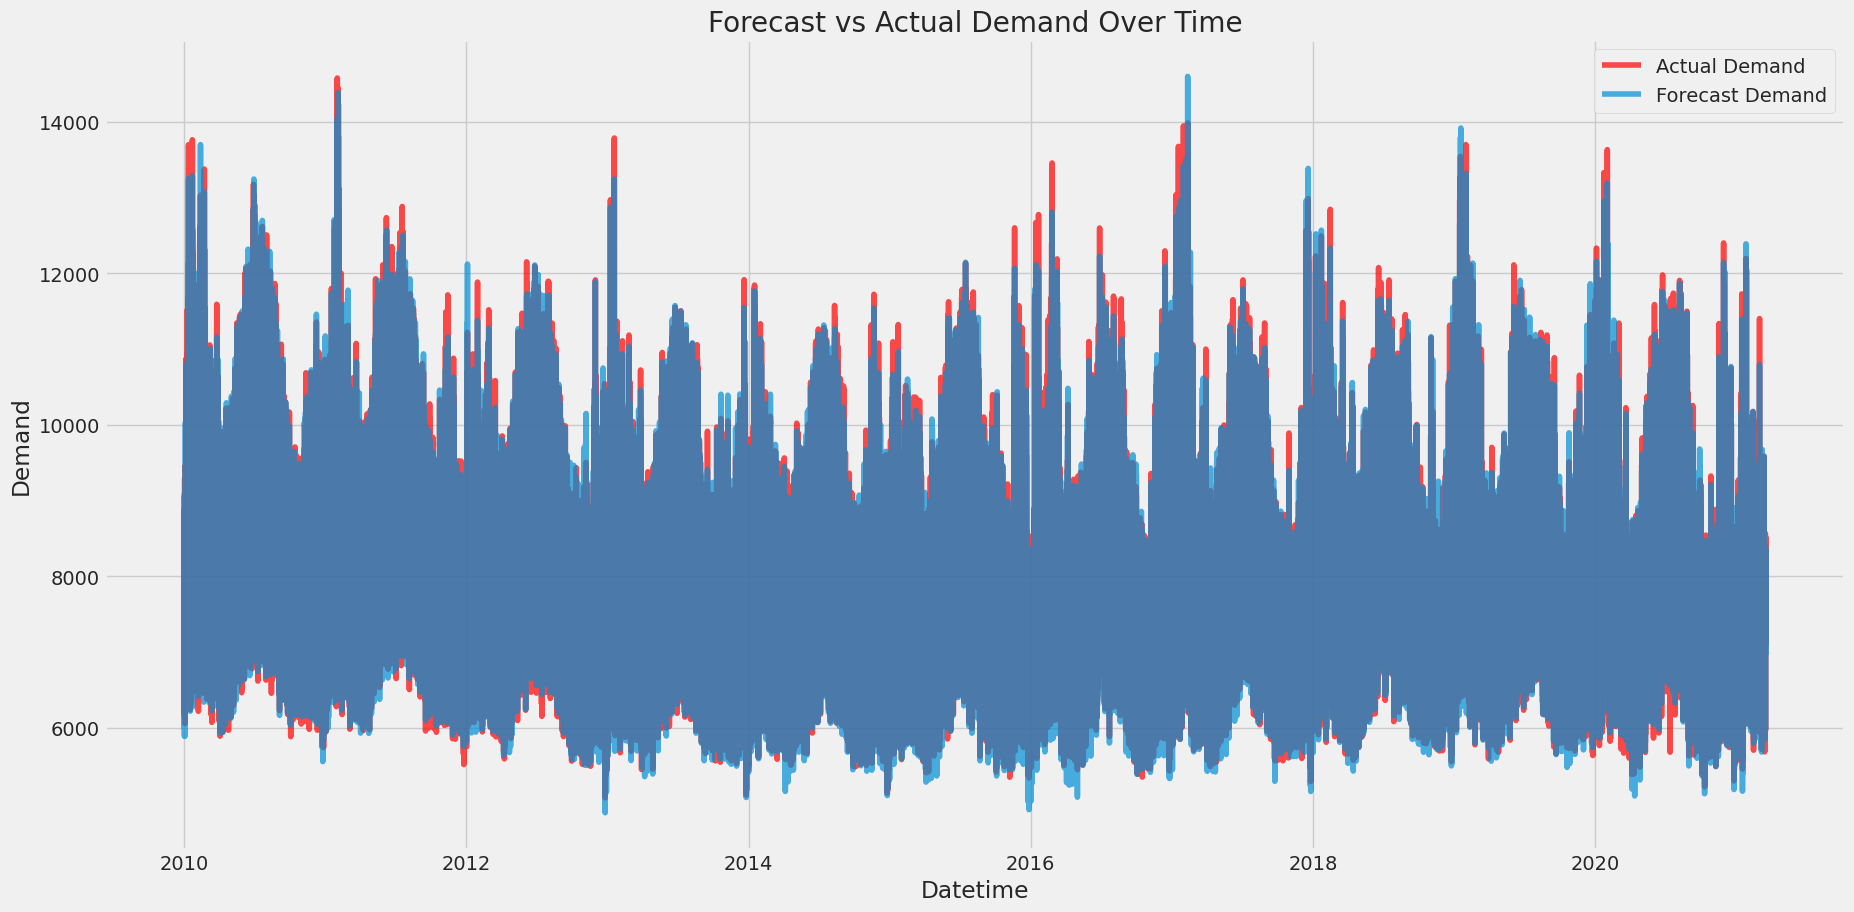

In [127]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.7
)
plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.7
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast vs Actual Demand Over Time')
plt.legend()
plt.show()

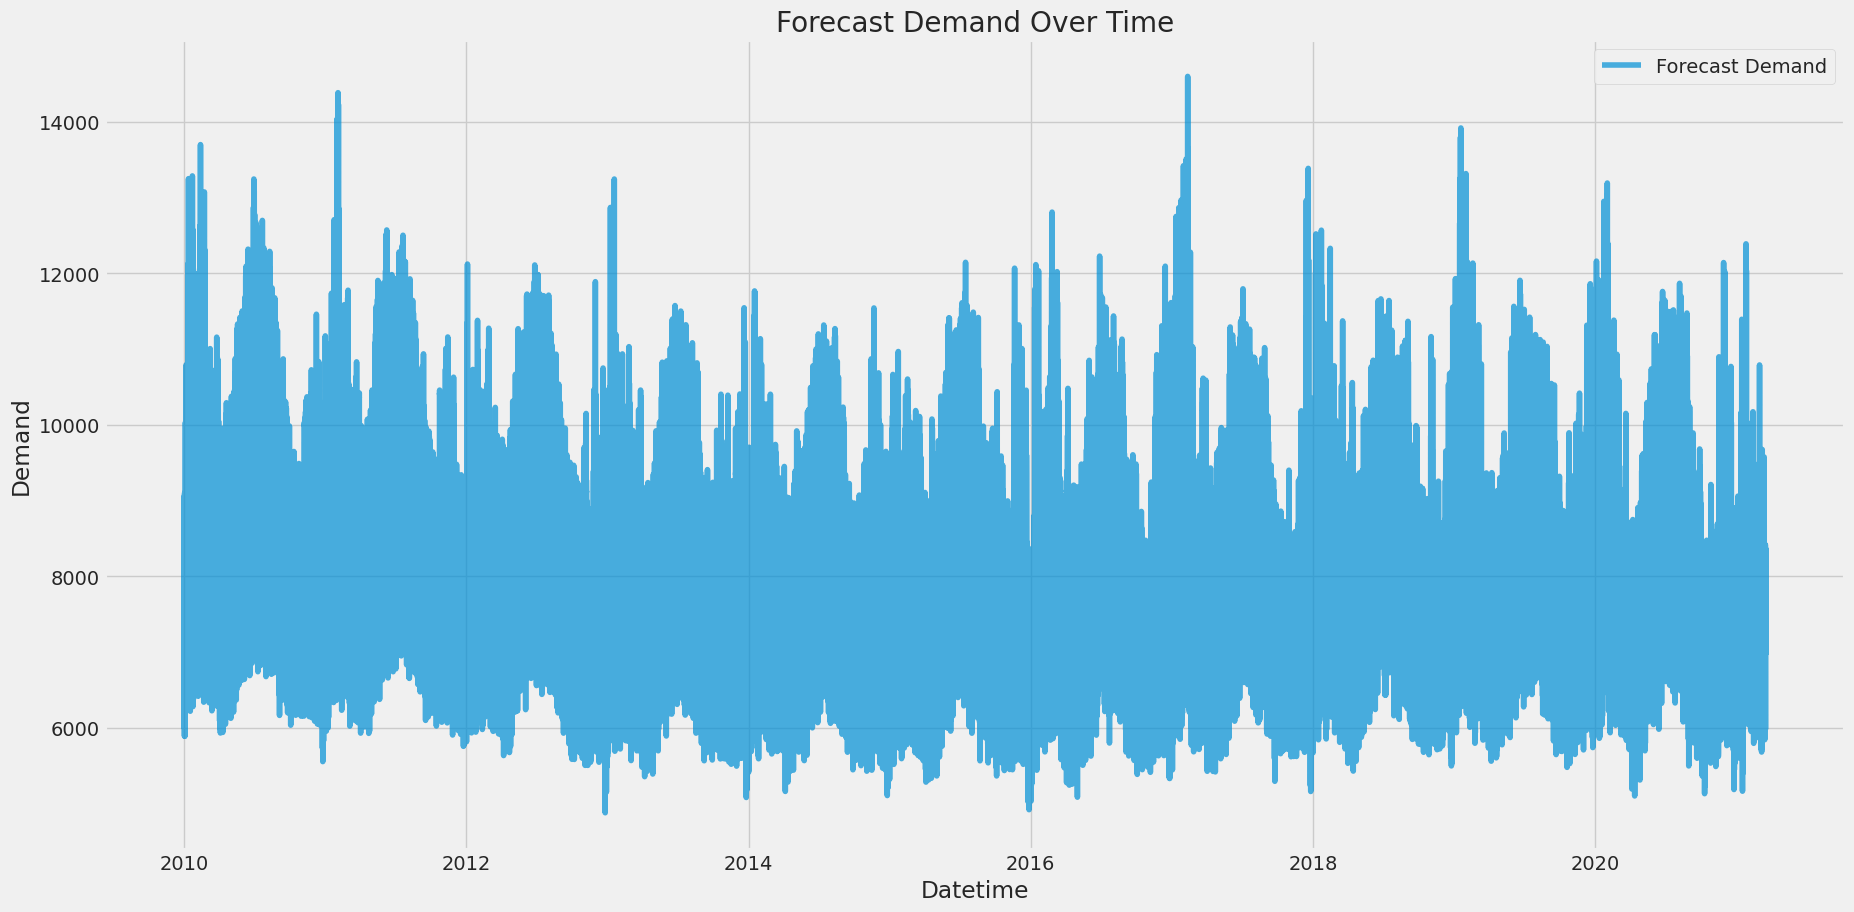

In [128]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.7
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast Demand Over Time')
plt.legend()
plt.show()

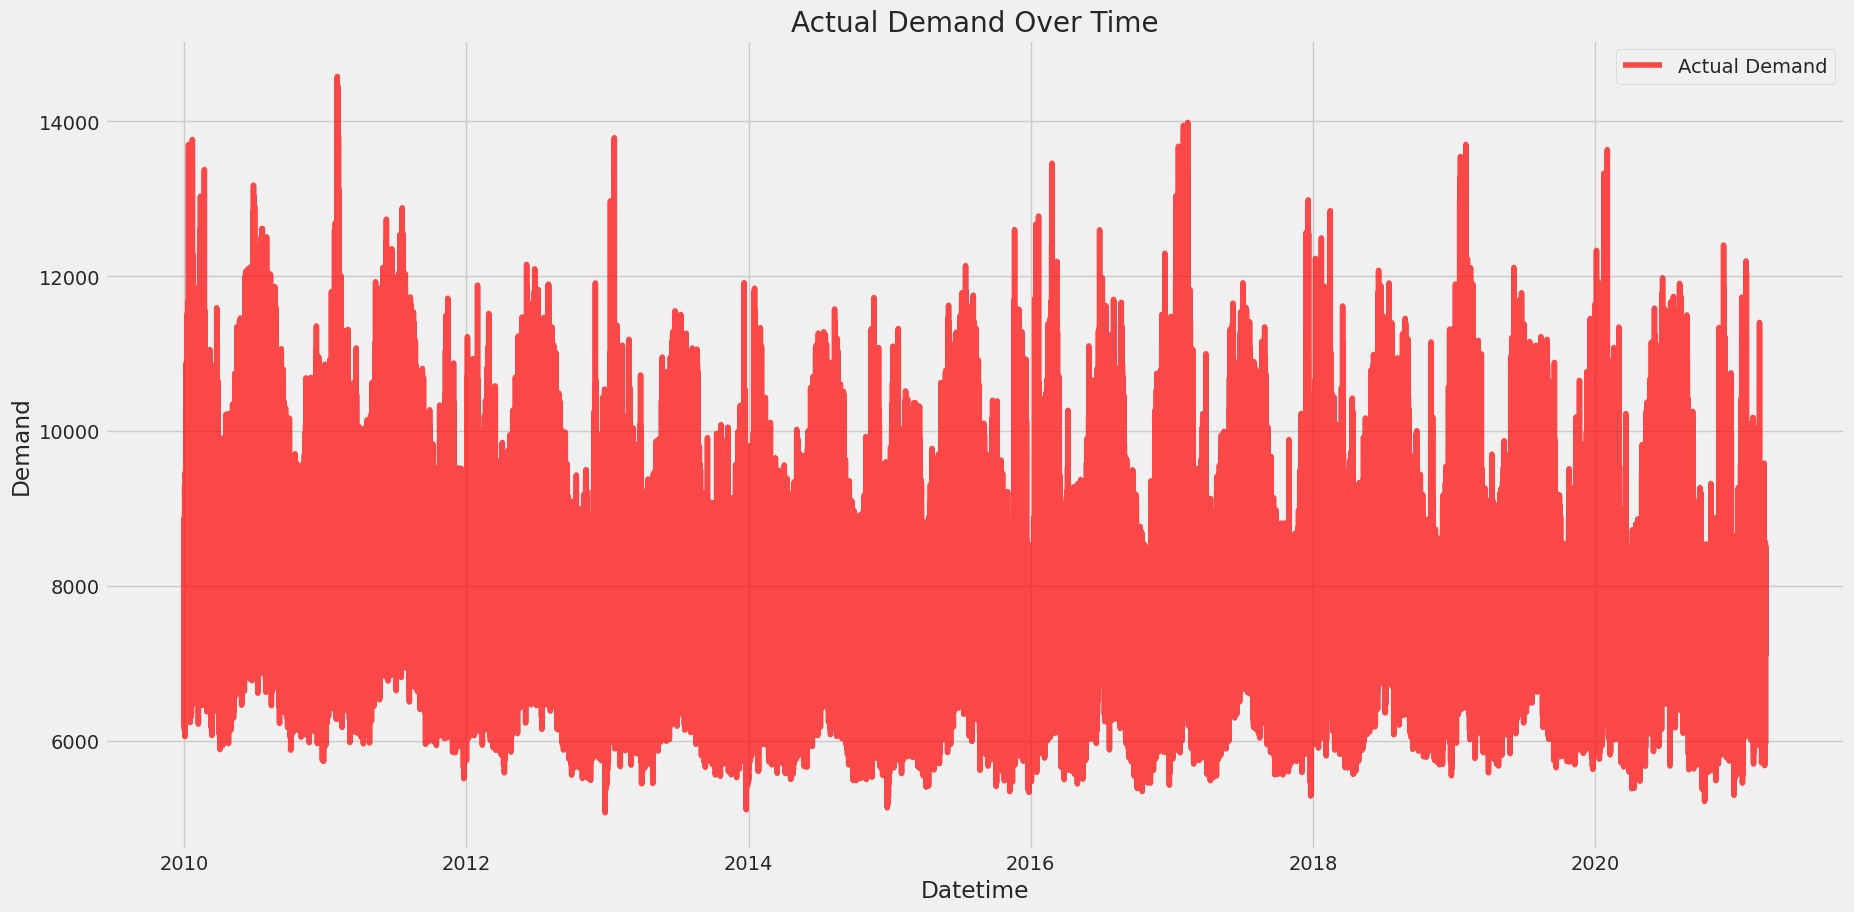

In [129]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.7
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual Demand Over Time')
plt.legend()
plt.show()

# Temperature over time

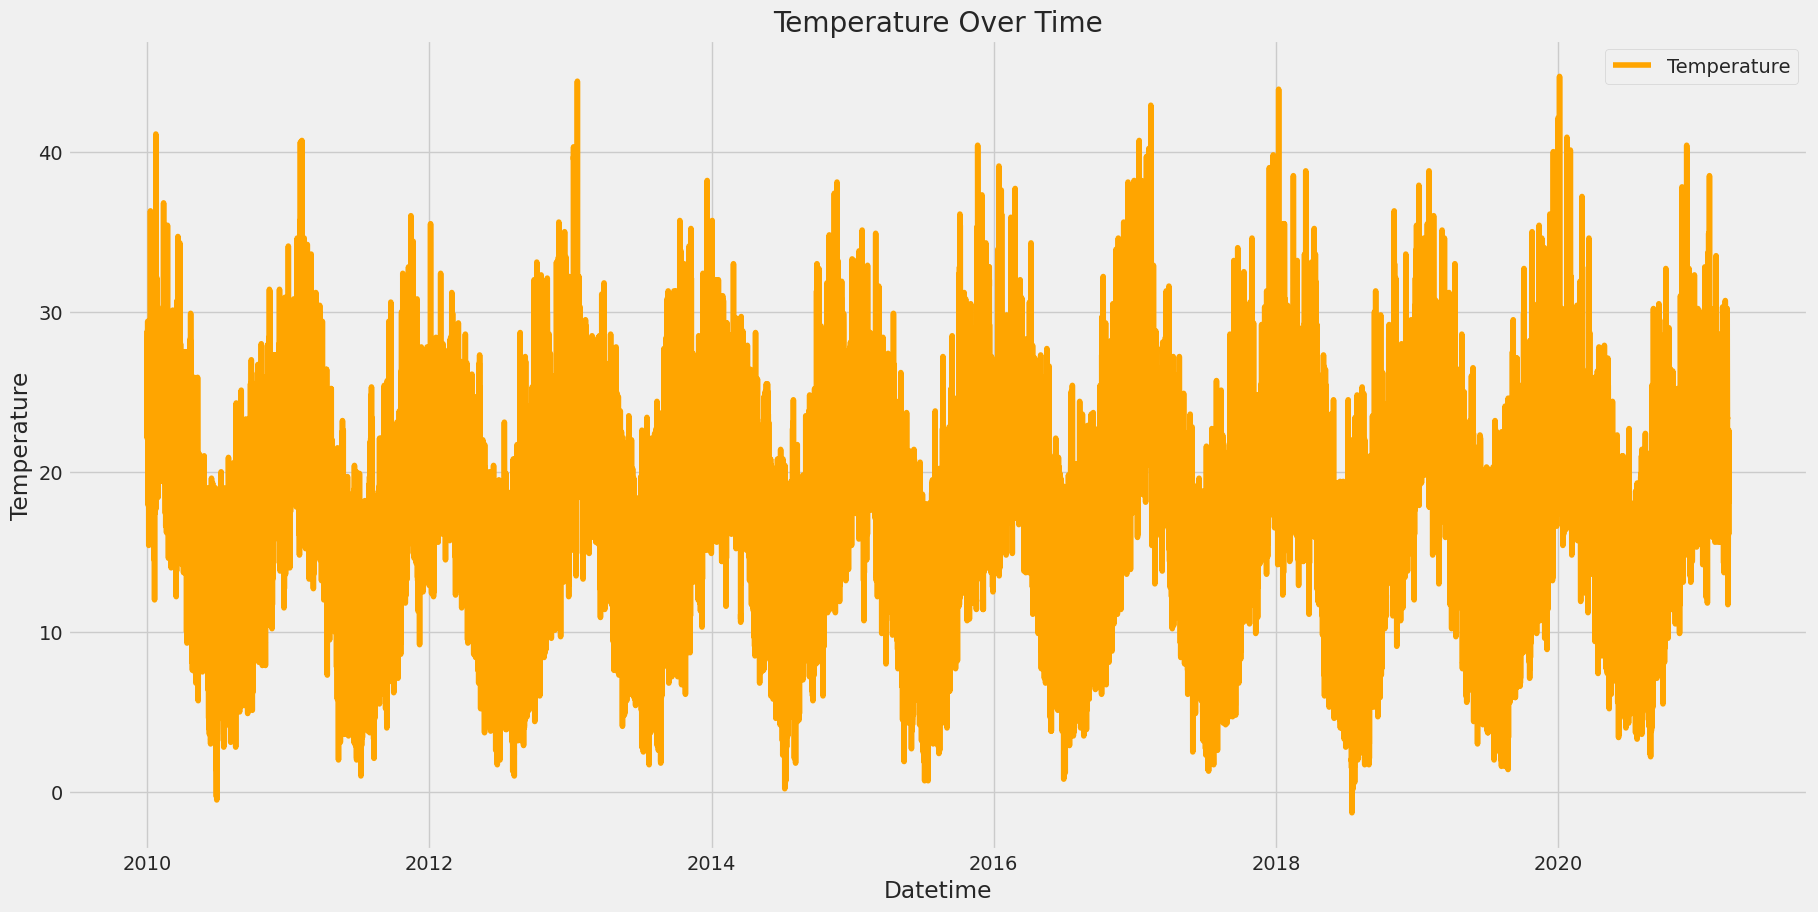

In [130]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TEMPERATURE'], 
    color='orange', 
    label='Temperature'
)
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.show()

## Scatter Plot: Temperature vs Demand
to see if higher or lower temperatures correlate with higher or lower demand

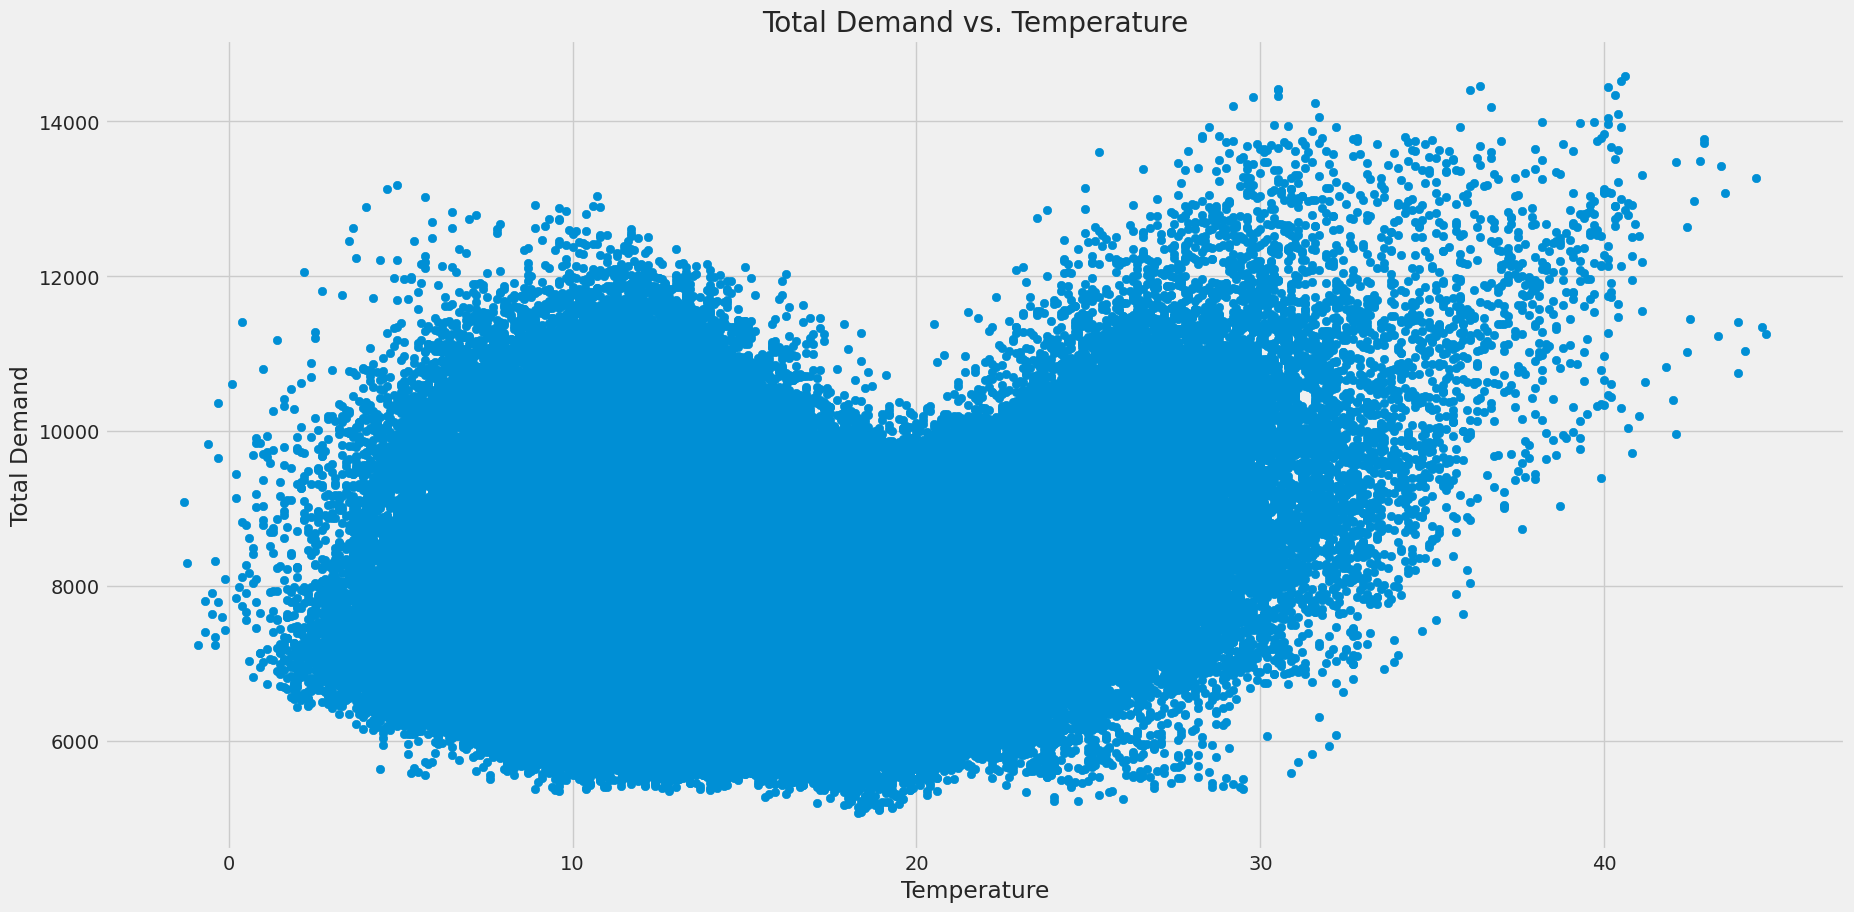

In [141]:
plt.scatter(nsw_df['TEMPERATURE'], nsw_df['TOTALDEMAND'])
plt.xlabel('Temperature')
plt.ylabel('Total Demand')
plt.title('Total Demand vs. Temperature')
plt.show()

# Scatter plot: Total demand vs time of day

# Scatter plot: Temperature vs Total Demand vs Forecast Demand

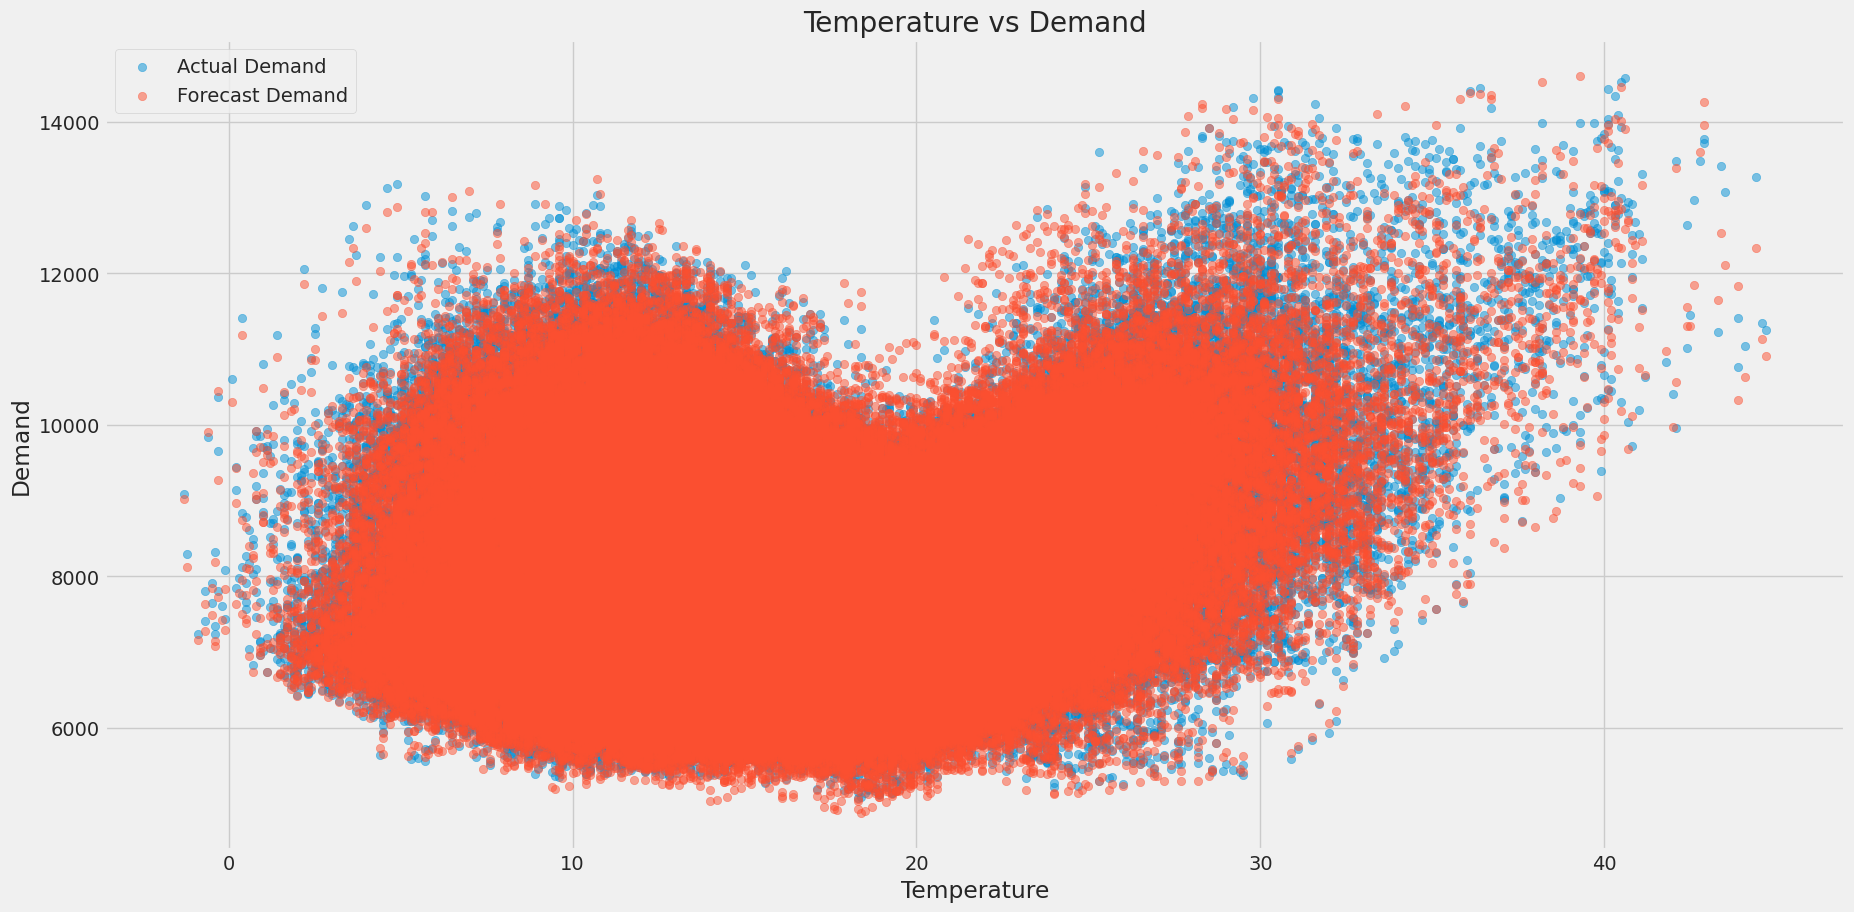

In [131]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.scatter(
    nsw_df['TEMPERATURE'], 
    nsw_df['TOTALDEMAND'], 
    label='Total Demand', 
    alpha=0.5
)
plt.scatter(
    nsw_df['TEMPERATURE'], 
    nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.5
)
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.title('Temperature vs Demand')
plt.legend()
plt.show()

## Histogram: total demand distribution
to get an idea of the most common demand levels

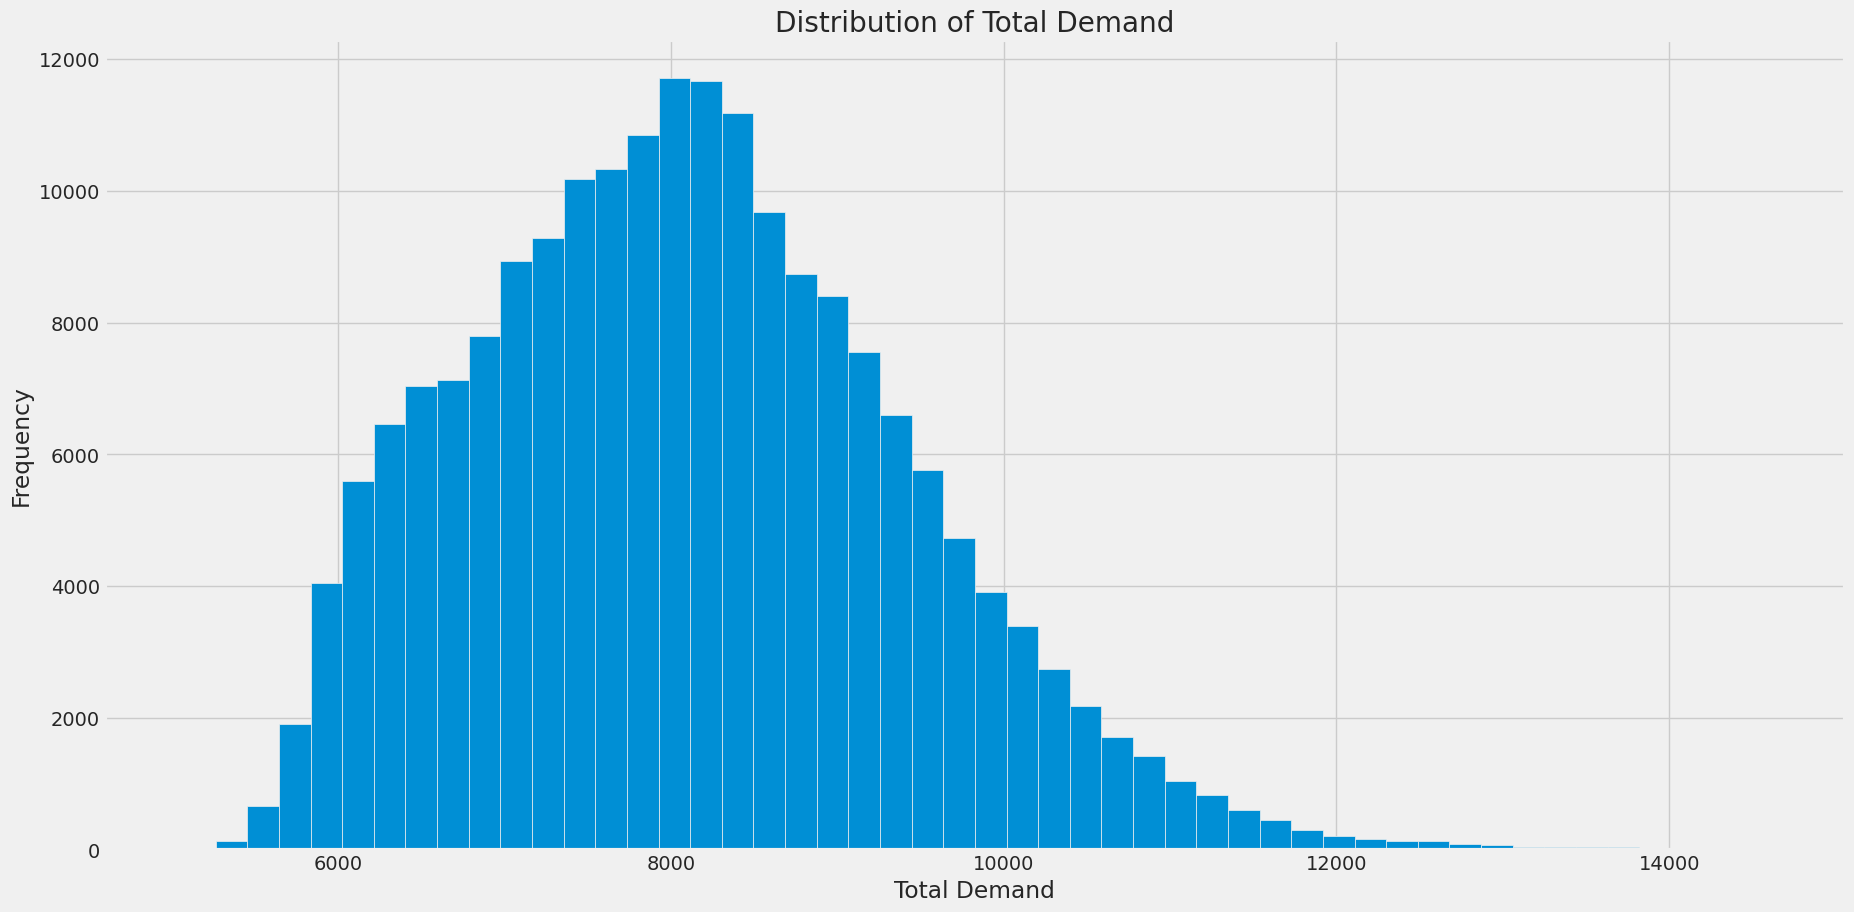

In [132]:
nsw_df['TOTALDEMAND'].hist(bins=50)
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

## Histogram: temperature distribution

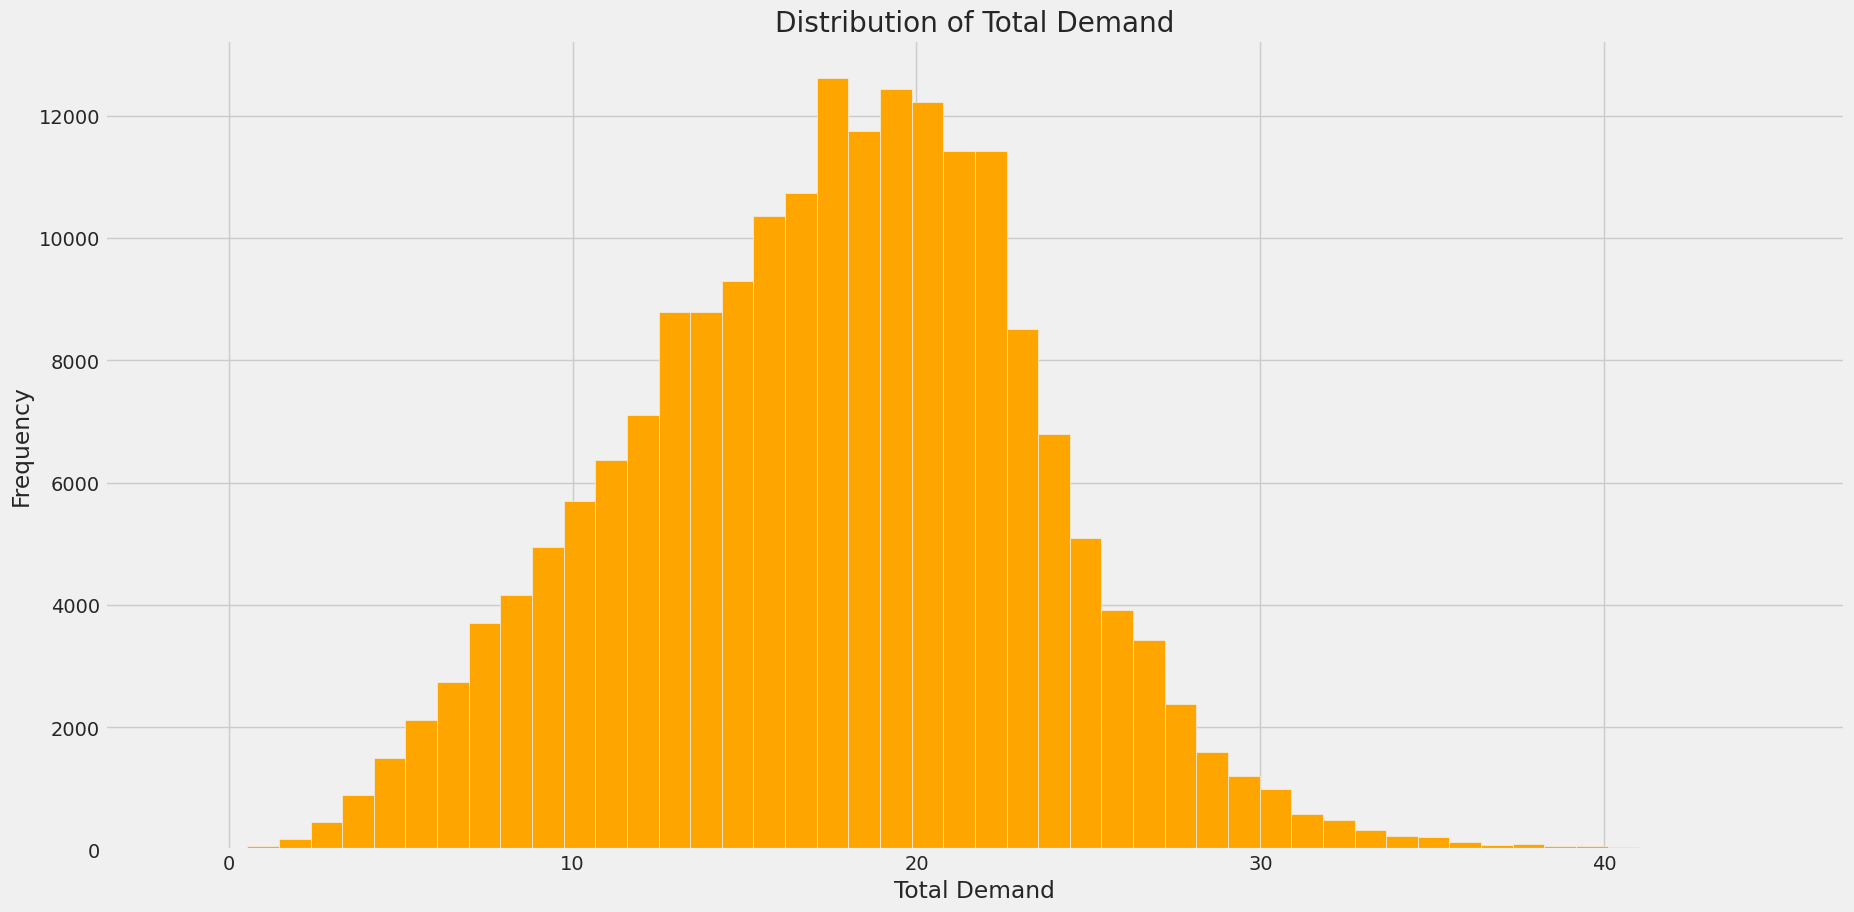

In [140]:
nsw_df['TEMPERATURE'].hist(bins=50, color='orange')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

# KDE of Total demand
to see the probability density of the total demand levels

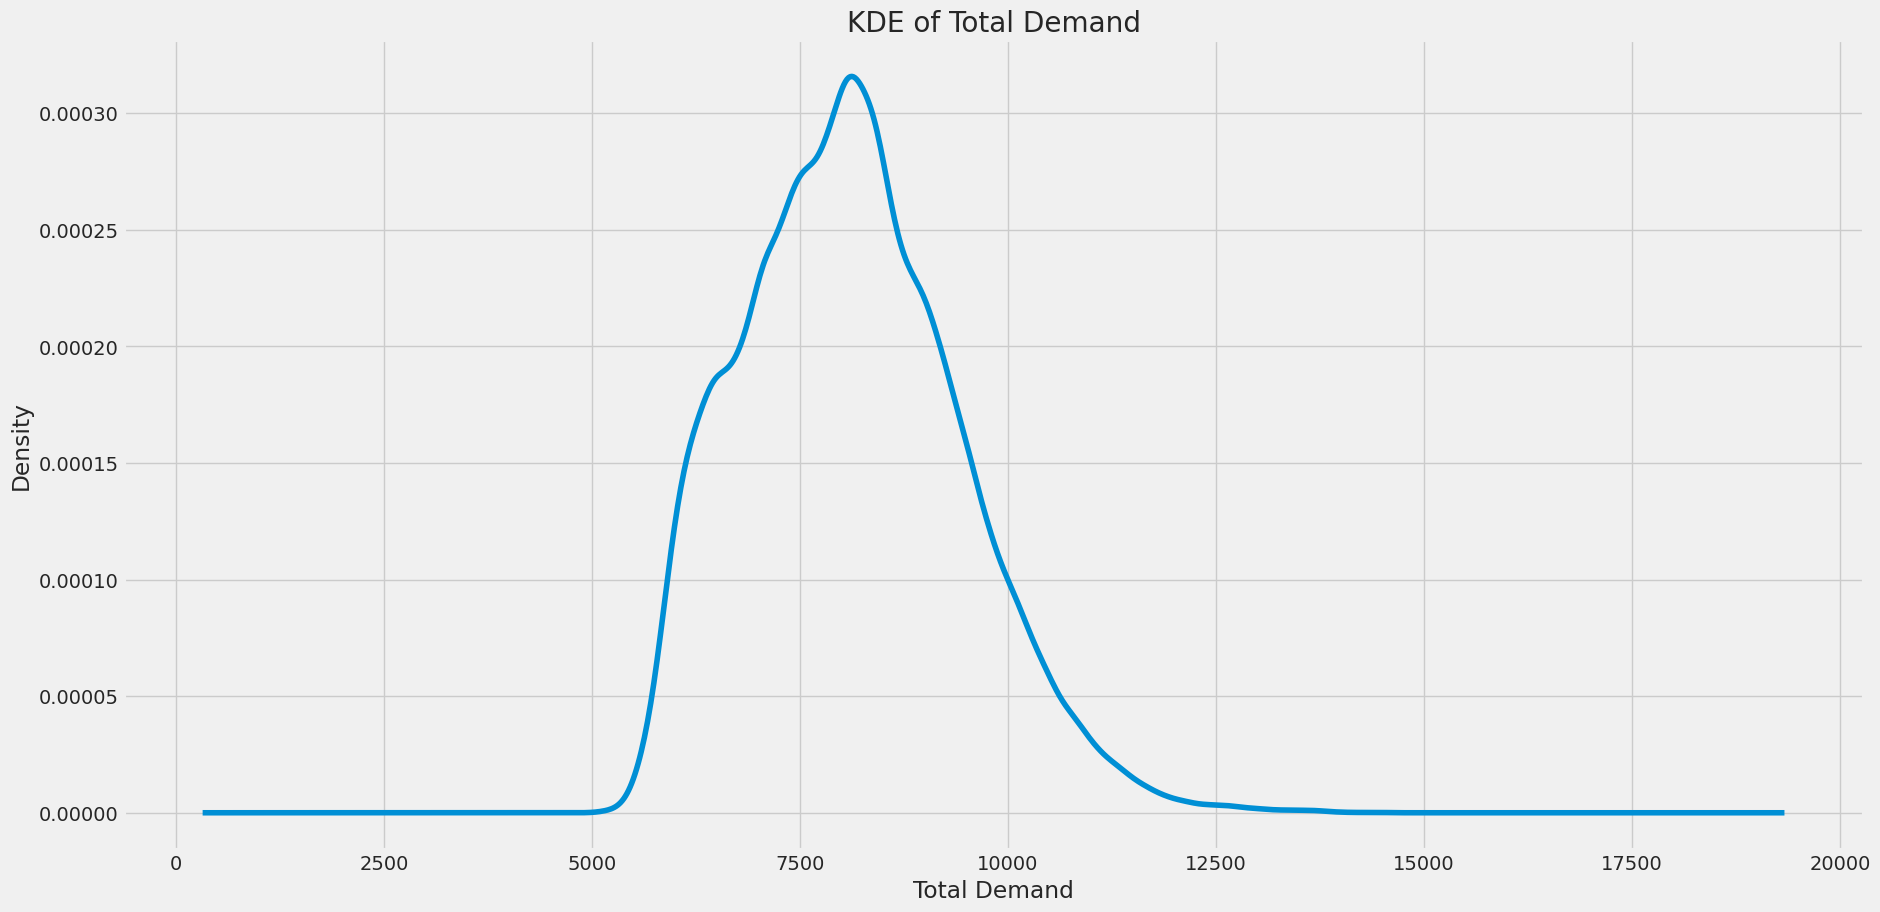

In [133]:
nsw_df['TOTALDEMAND'].plot(kind='kde')
plt.xlabel('Total Demand')
plt.title('KDE of Total Demand')
plt.show()

# Boxplot
consider taking the log so that scale isn't an issue

<Figure size 2000x1000 with 0 Axes>

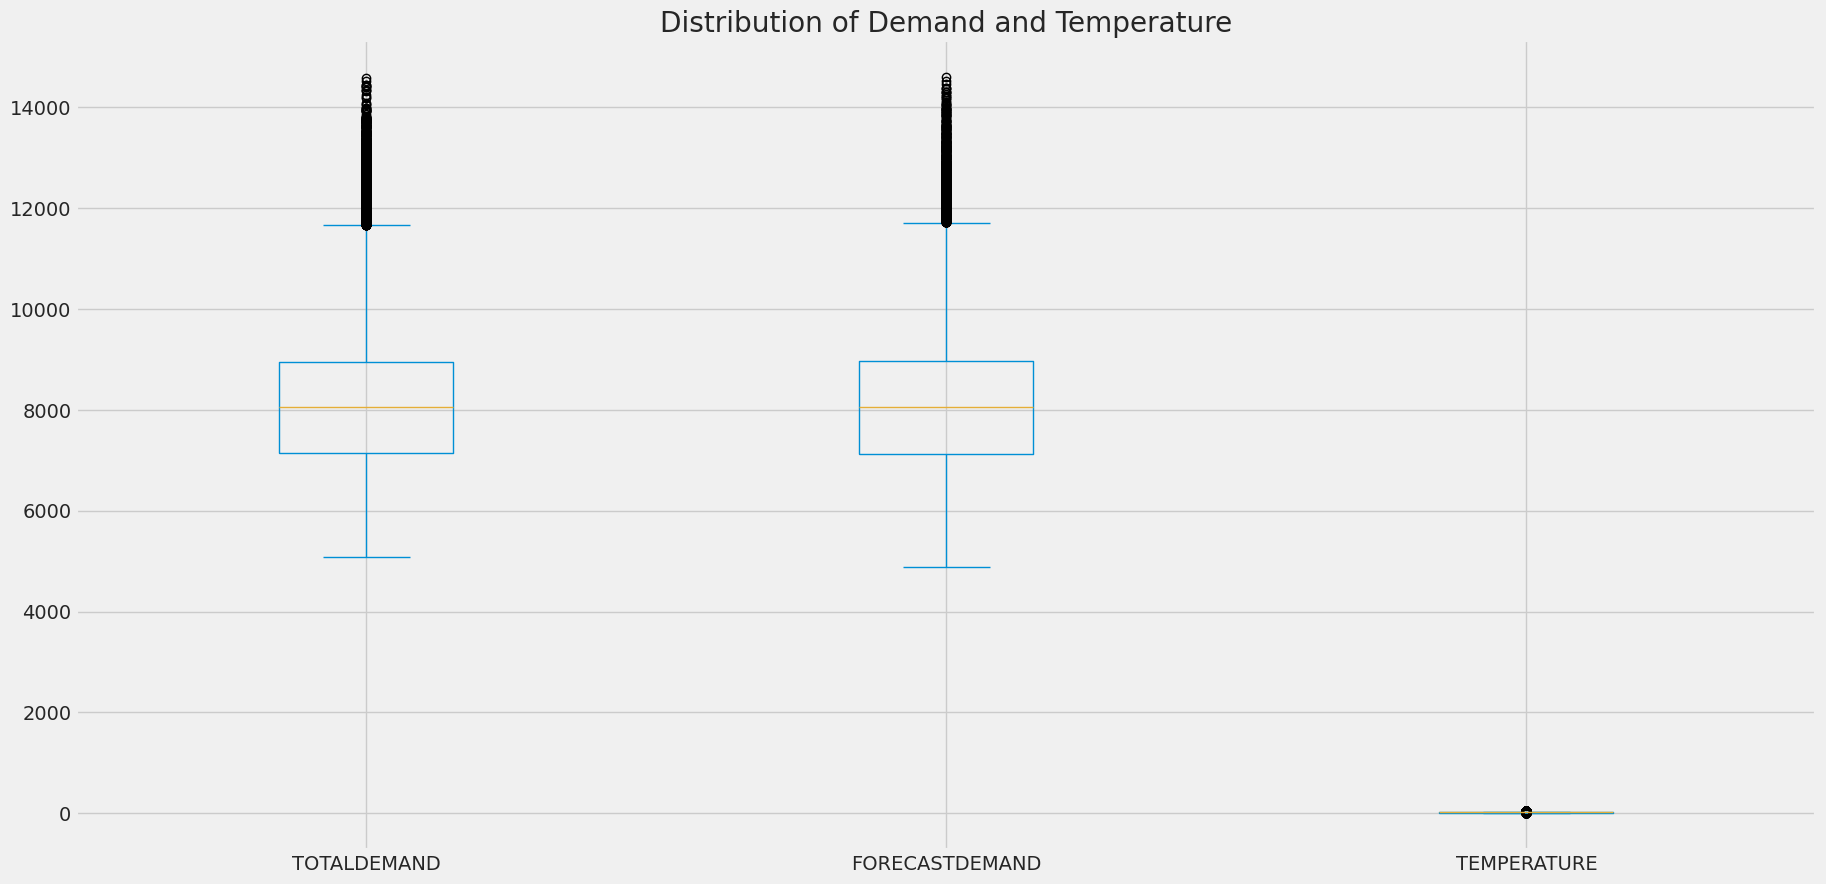

In [134]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
nsw_df.plot(kind='box')
plt.title('Distribution of Demand and Temperature')
plt.show()

# Decomposition

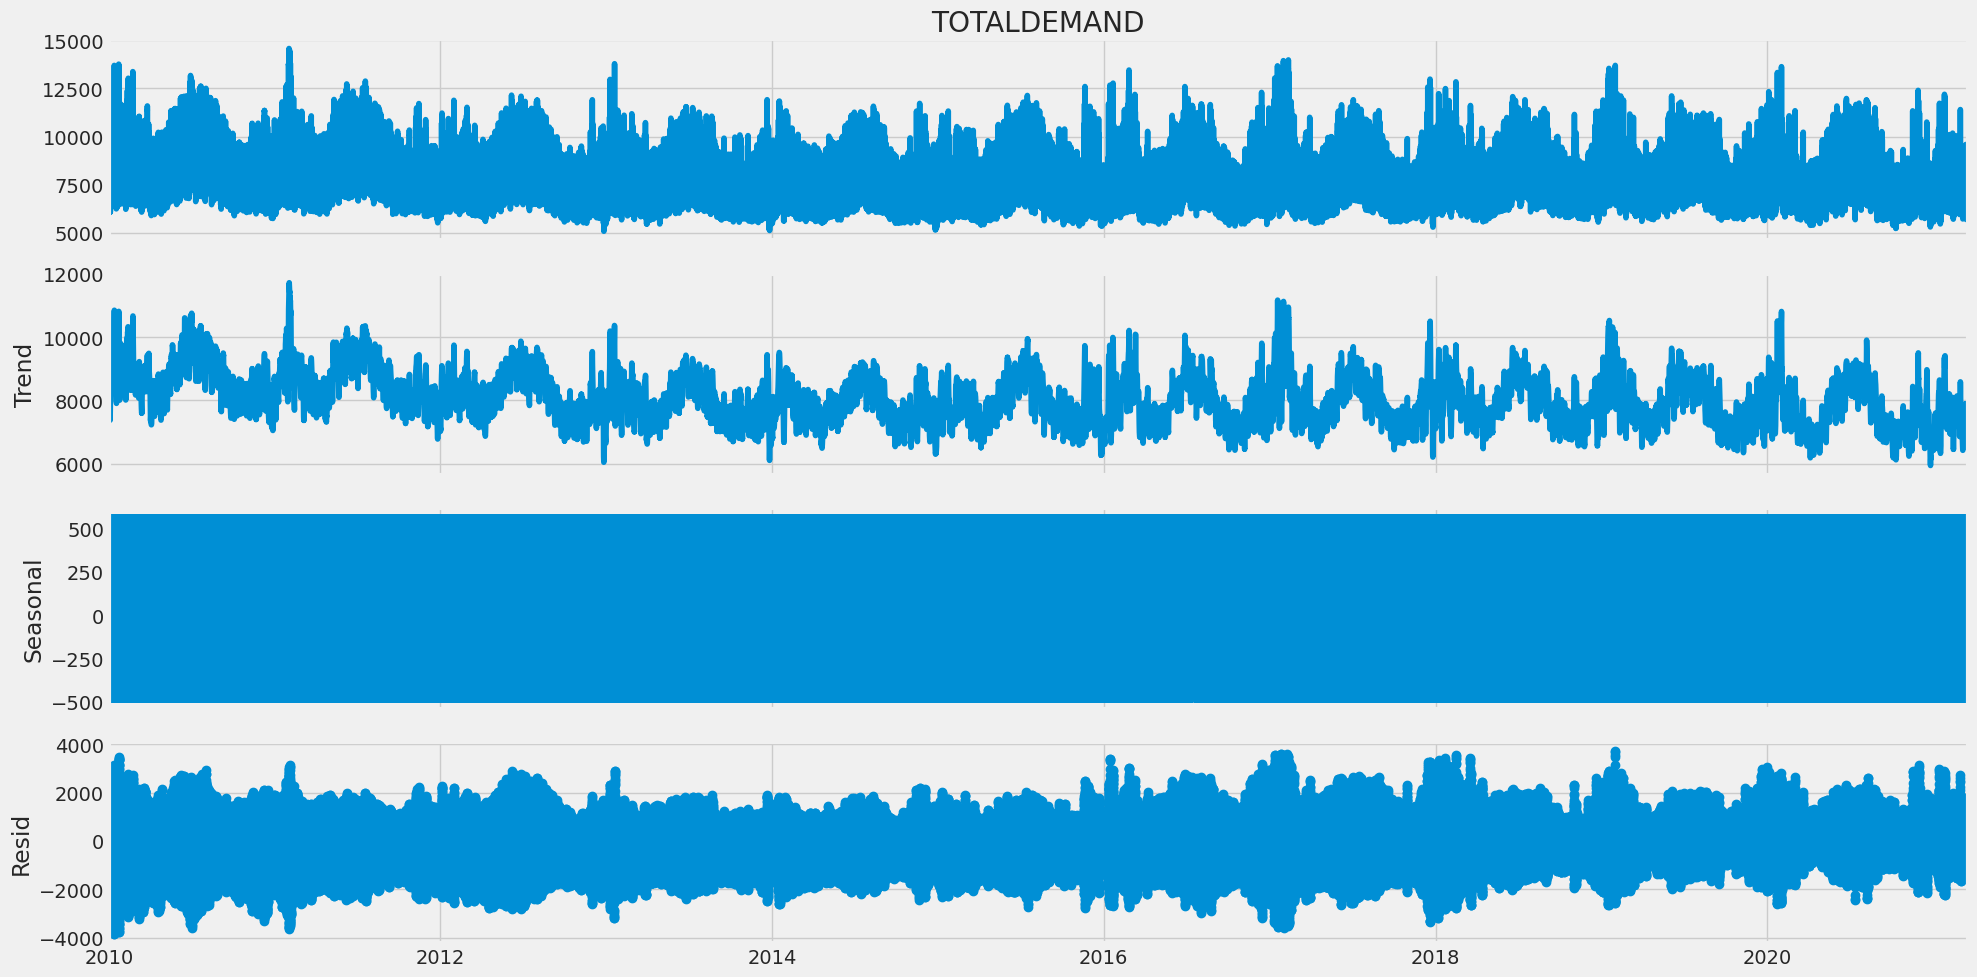

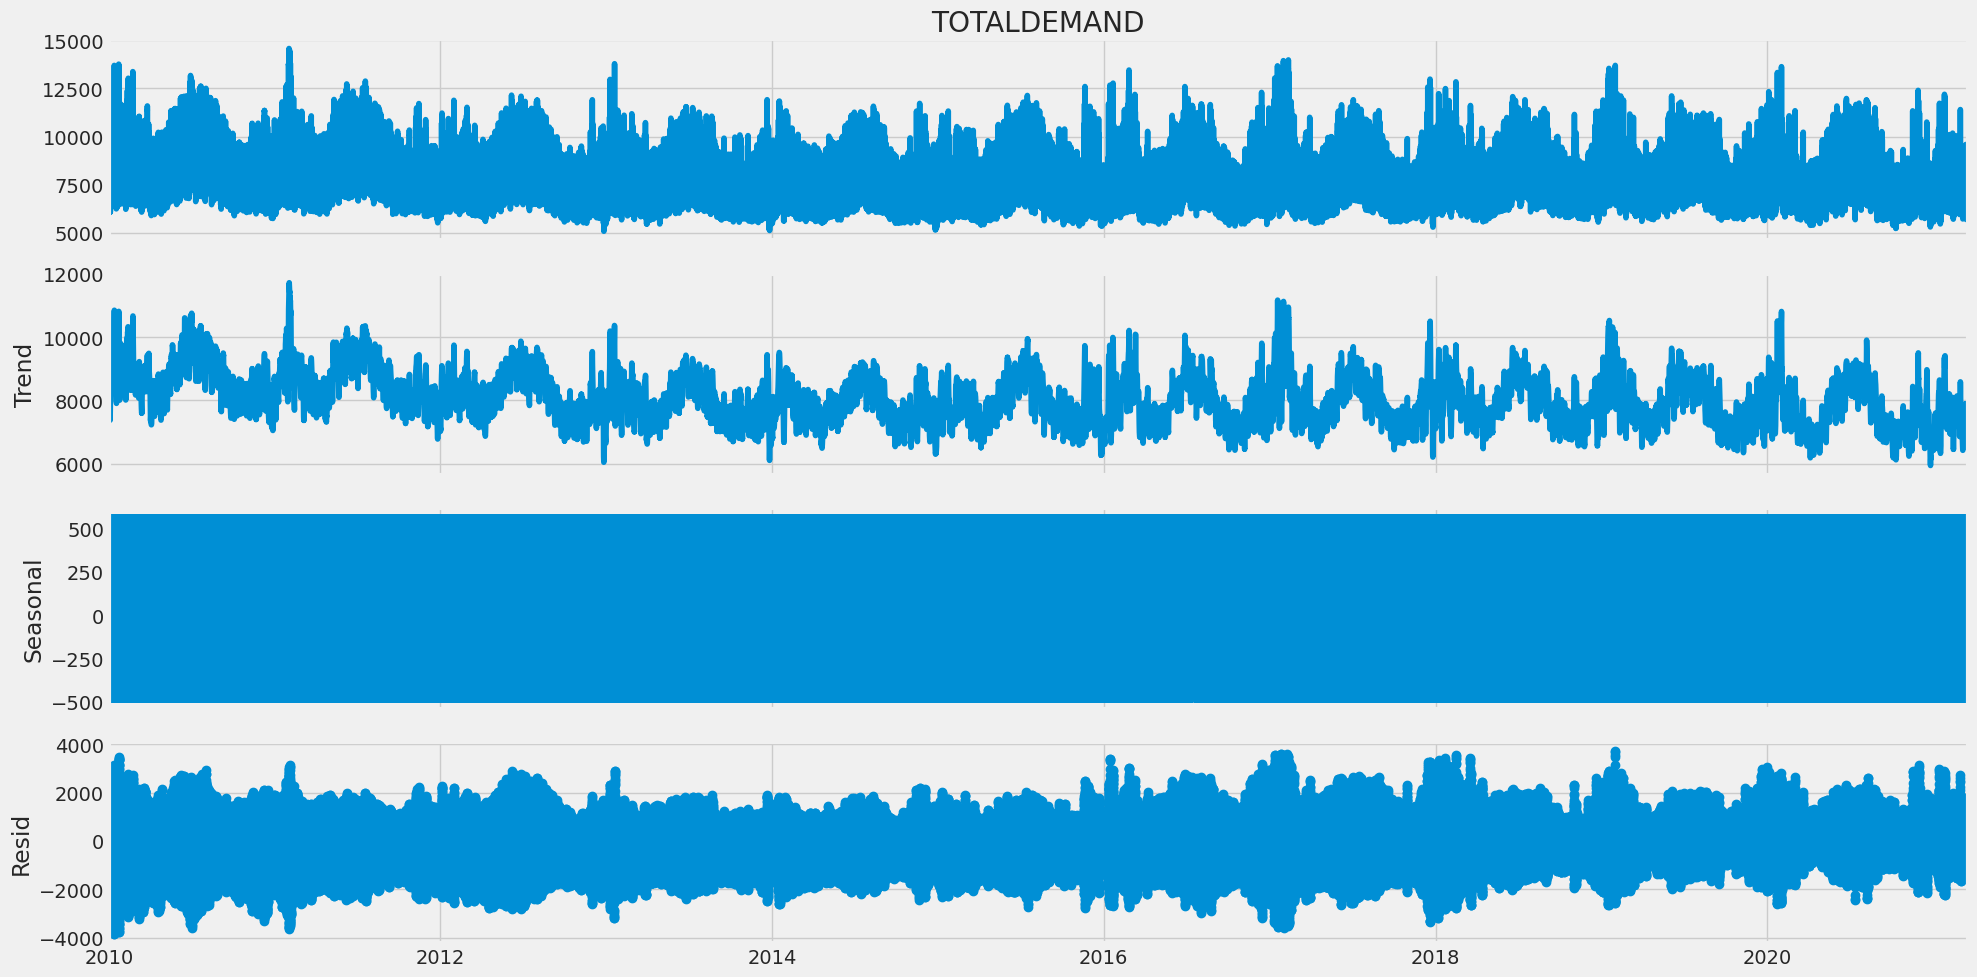

In [135]:
res = seasonal_decompose(
    nsw_df['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res.plot()

# Decomposition of 1 year of data

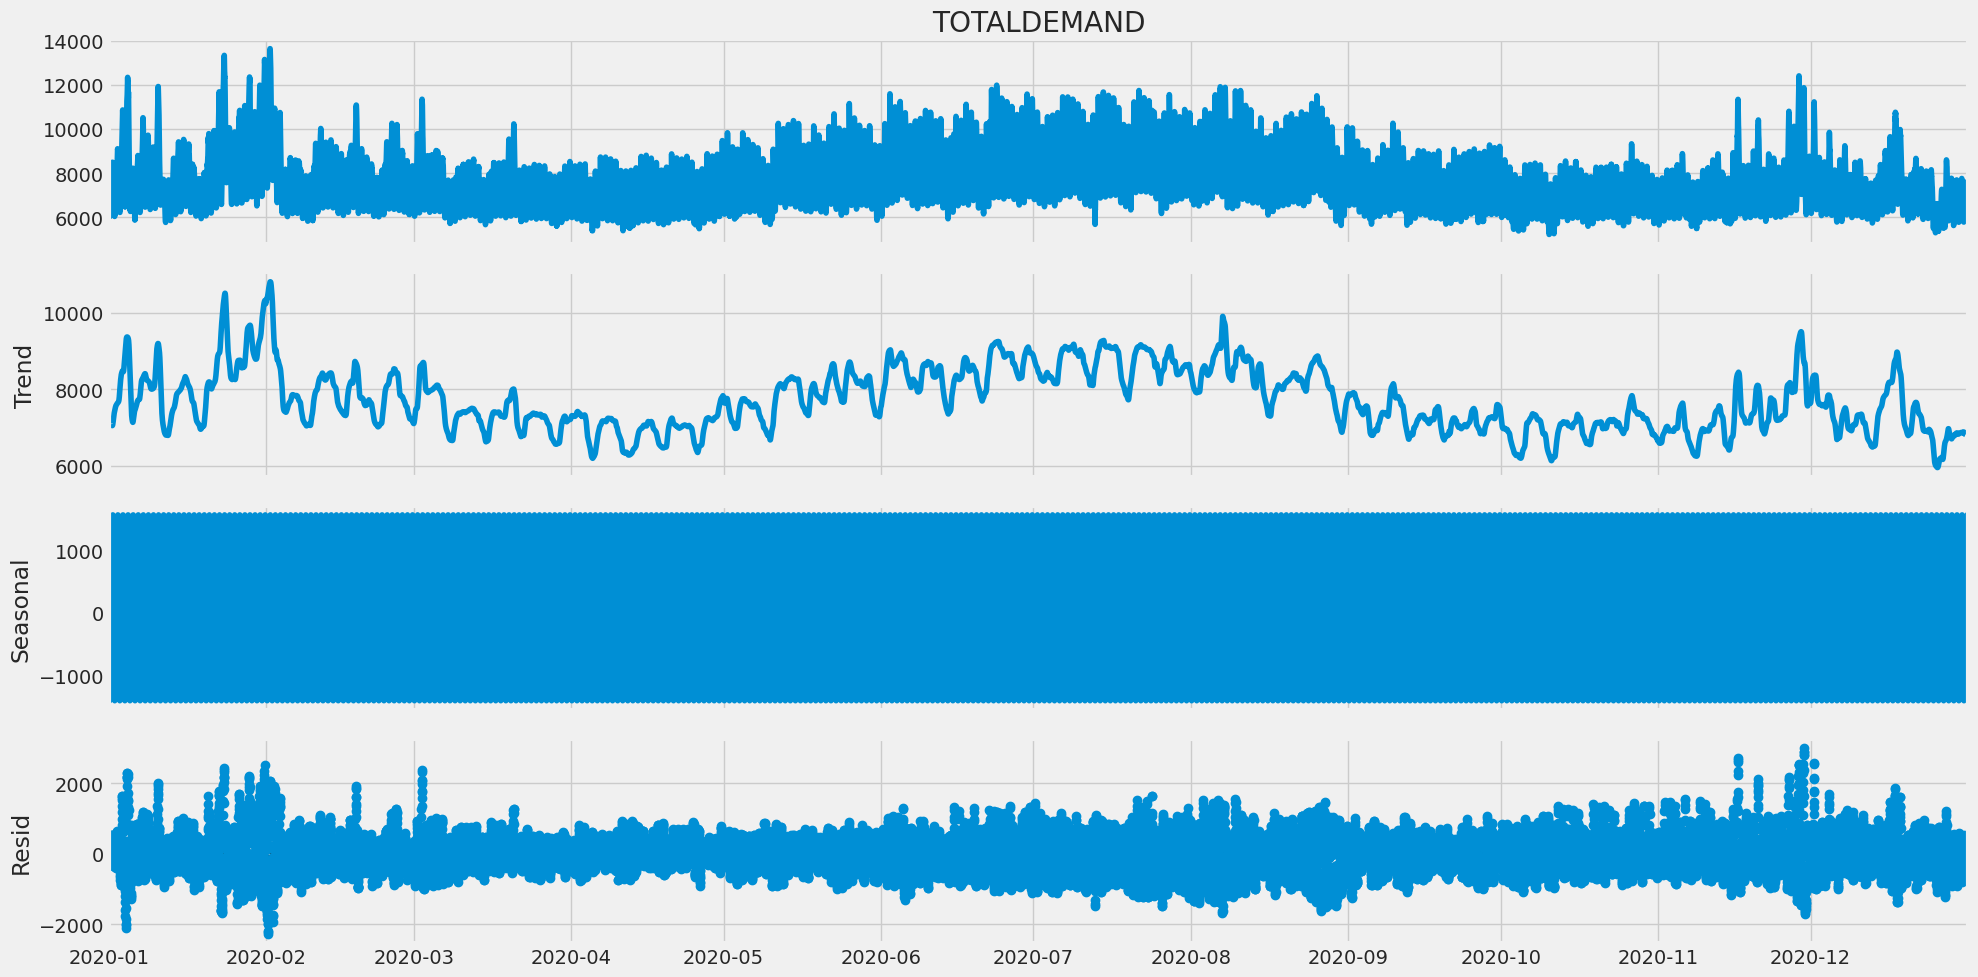

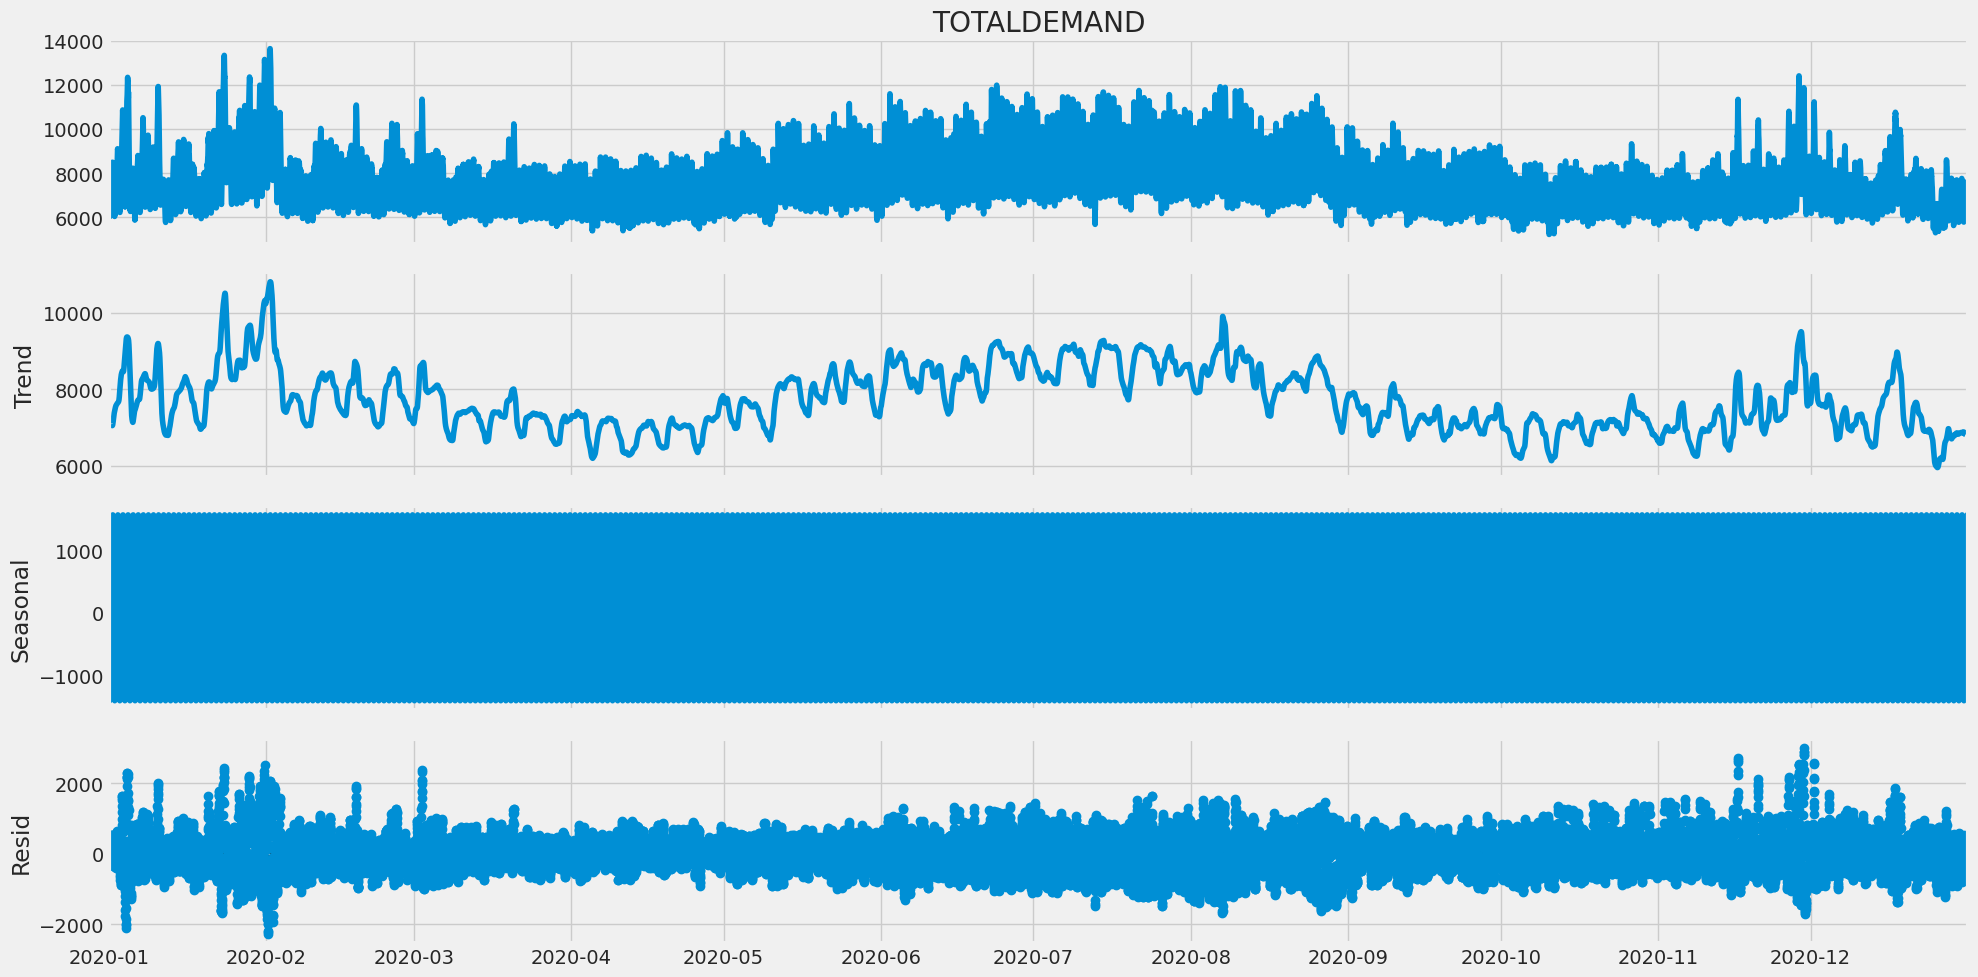

In [136]:
one_year_data = nsw_df.loc['2020']
res_one_year = seasonal_decompose(
    one_year_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_year.plot()

### decompose for one week

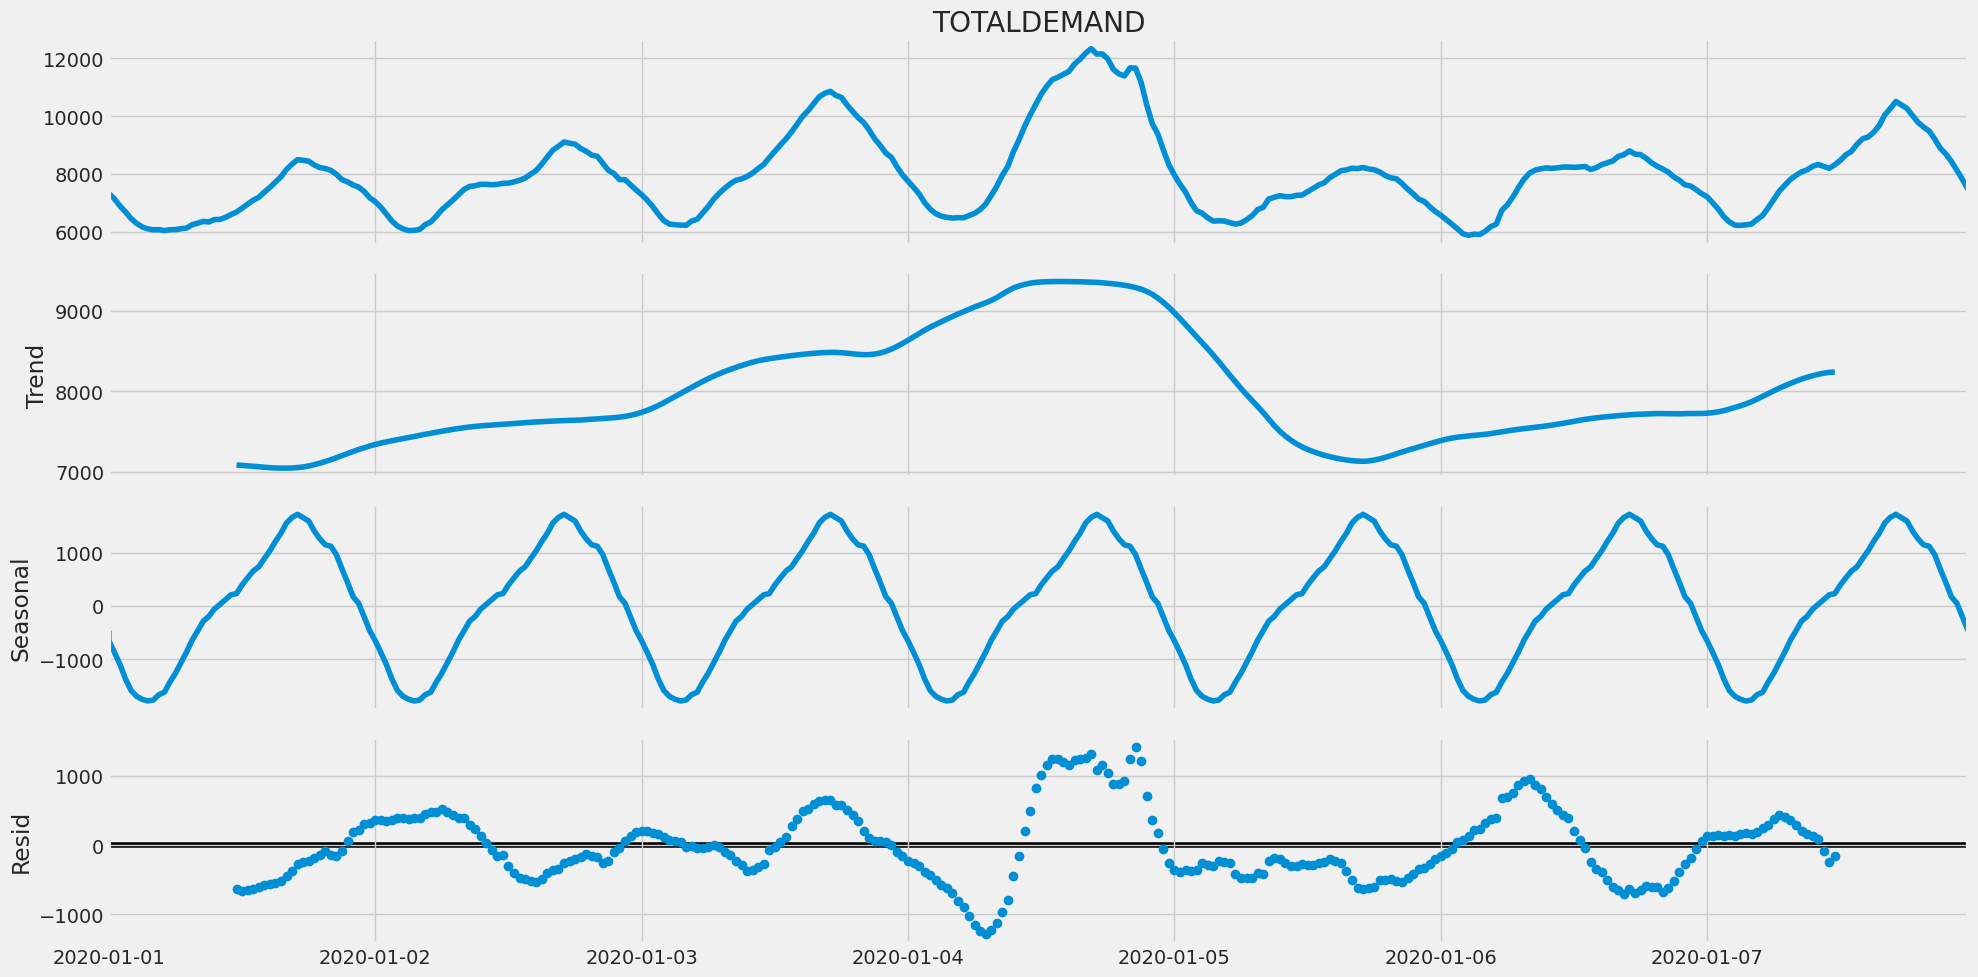

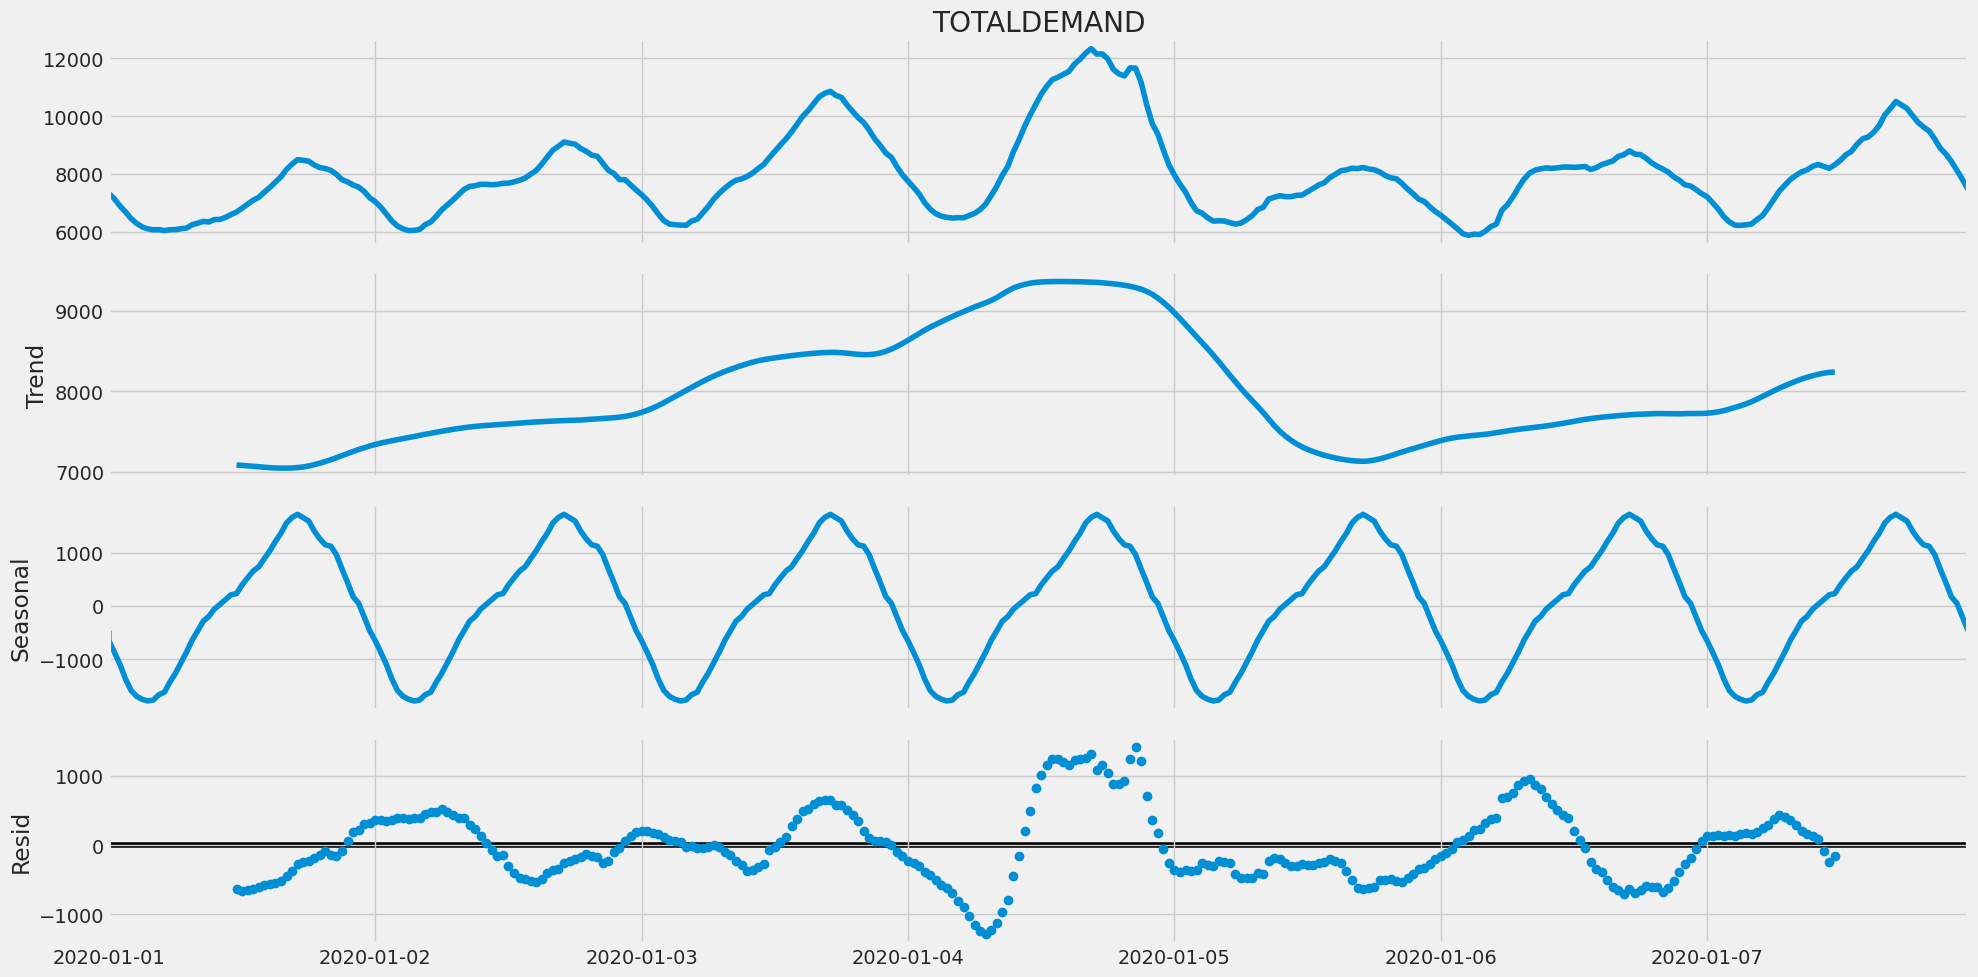

In [137]:
one_week_data = nsw_df['2020-01-01':'2020-01-07']
res_one_week = seasonal_decompose(
    one_week_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_week.plot()

### Decompose for 2 days

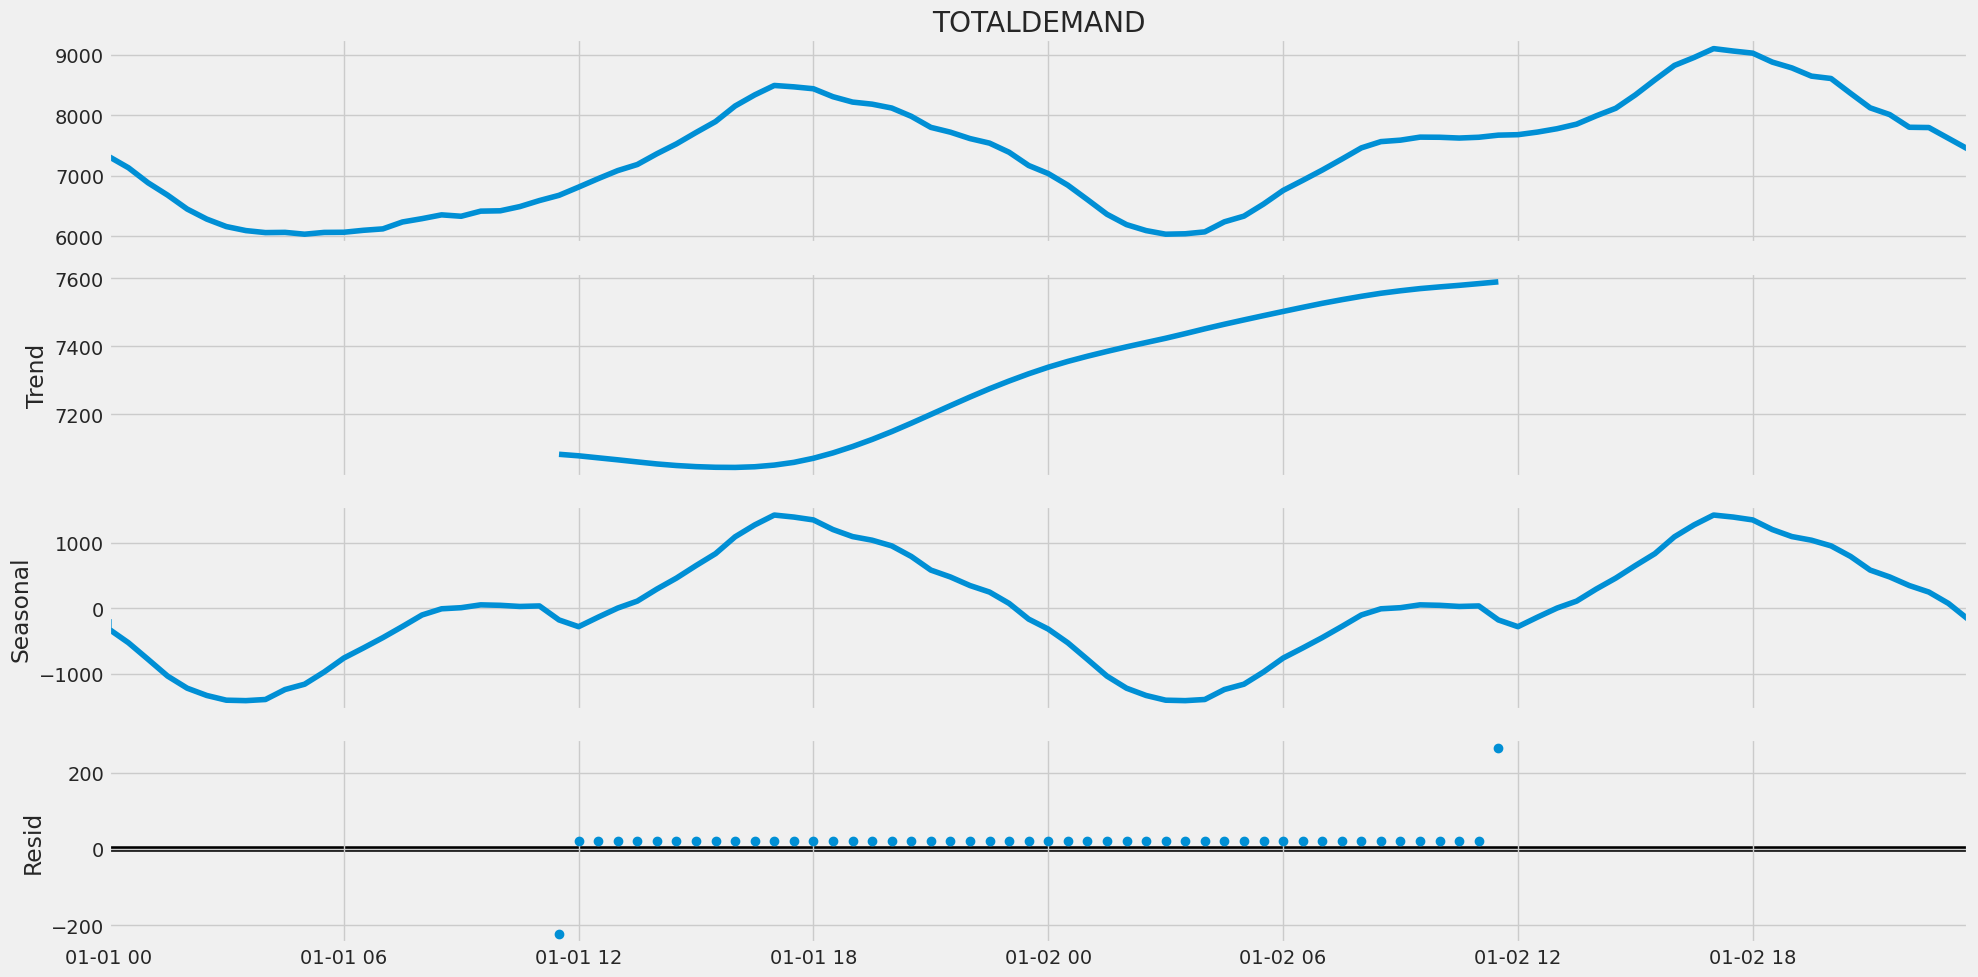

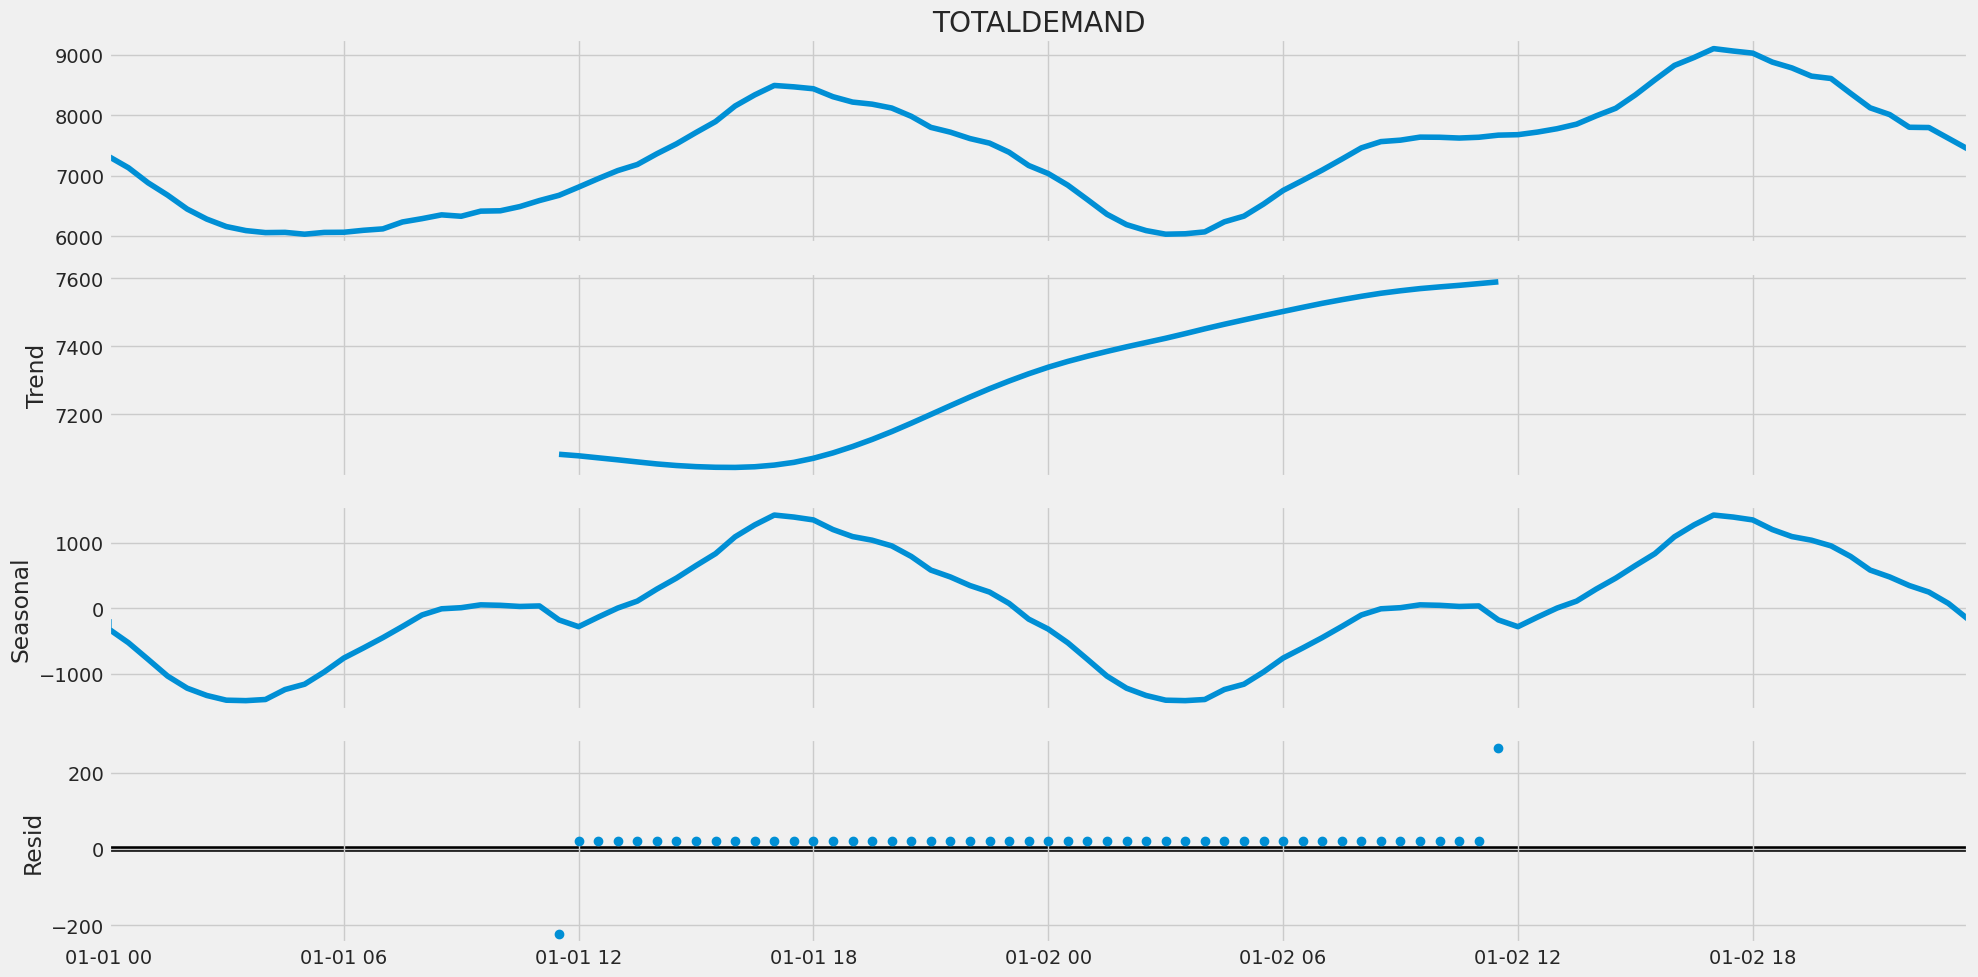

In [138]:
one_day_data = nsw_df['2020-01-01 00:00:00':'2020-01-02 23:30:00']
res_one_day = seasonal_decompose(
    one_day_data['TOTALDEMAND'], 
    model='additive',
    period=48
)
res_one_day.plot()

# Rolling statistics

# autocorrelation analysis (ACF and PACF)

# Day / Hour breakdwon

# How can we measure the current accuracy of the forecast demand vs actual demand?

# How can i do deocmposition, seasonality etc? Is that part of feature engineering or EDA?

# Data Cleaning

# Feature Engineering

# Model Selection & Development

# model tuning and evaluation

# insights and action